# Natural Language Processing Demystified | Neural Networks Foundations
https://nlpdemystified.org<br>
https://github.com/futuremojo/nlp-demystified

# Neural Networks I: Core Mechanisms and Coding One From Scratch

Course module for this demo: https://www.nlpdemystified.org/course/neural-networks-1

To get a better handle on neural networks, we're going to build one from scratch. We'll do this in two phases:
1. We'll first perform every calculation of a forward pass and backward pass (i.e. backpropagation) step-by-step and examine the inputs and outputs along the way.<br><br>
2. We'll then encapsulate all this functionality into classes, and then use these classes to compose a neural network which we'll train on a randomly generated dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_gaussian_quantiles

## A Complete Forward and Backward Pass, Step-by-Step


### The dataset
We'll demonstrate the forward and backward passes on this made-up dataset. It consists of five examples with three features each, and binary True/False labels. Unlike in the slides, we'll process this data as a whole rather than one sample at a time. This will expose us to matrix operations.

In [2]:
samples = np.array([
  [1, 2, 3],
  [6, 7, 8],
  [7, 8, 9],
  [3, 4, 5],
  [4, 5, 6],
])

# By convention, inputs in matrix form are often denoted by a capital X.
X = samples

targets = np.array([False, True, True, False, False])

The goal would be a neural network to classify inputs as either True or False. This is the neural network architecture we'll follow:

00001.svg

A few notes about this architecture:
1. It has a single hidden layer of four units, and an output layer of two units feeding into a softmax since we're classifying into two categories.<br><br>
2. In the slides, we described using a **sigmoid** activation function in the output layer and a **binary** cross-entropy (CE) loss function for binary classification, so you may be wondering why we're using a **softmax** activation function with **categorical** cross-entropy loss (CCE) instead. In NLP, softmax with CCE is more common, so we're using it here for exposure and practice. And it's fine because softmax is a generalization of sigmoid, and CCE is a generalization of CE.<br><br>
3. Rather than setting up the bias as a constant input of 1 with its own weight, we'll include the bias in the "traditional" manner (adding it). This is just to make things more explicit.

Since we're using softmax, $\hat{y}$ is going to be a probability distribution. So to calculate the loss, we'll one-hot encode the targets.<br><br>
We'll use NumPy's *unique* function which identifies the unique elements of an array. The *return_inverse* option also returns their indices.<br>
https://numpy.org/doc/stable/reference/generated/numpy.unique.html

In [3]:
uniques, indices = np.unique(targets, return_inverse=True)
print(f"Original targets: {targets}")
print(f"Unique values: {uniques}")
print(f"Target indices: {indices}")

Original targets: [False  True  True False False]
Unique values: [False  True]
Target indices: [0 1 1 0 0]


We'll create a matrix of zeros with dimension *dataset size* by *number of classes*.<br>
https://numpy.org/doc/stable/reference/generated/numpy.zeros.html

In [4]:
n_samples = targets.shape[0]
n_classes = len(uniques)
y = np.zeros((n_samples, n_classes))
print(y)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


We can now create our one-hot encodings using *arange* which generates a sequence. We'll use this sequence to index into each row of the target matrix and use the *indices* array to set the correct target slot to 1.<br>
https://numpy.org/doc/stable/reference/generated/numpy.arange.html

In [5]:
print(np.arange(n_samples))
print(indices)

[0 1 2 3 4]
[0 1 1 0 0]


In [6]:
y[np.arange(n_samples), indices] = 1
print(targets, '\n')
print("Our one-hot encoded targets:")
print(y)

[False  True  True False False] 

Our one-hot encoded targets:
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


### The Forward Pass

In [7]:
# The shape of our dataset.
print(X.shape)

n_features = X.shape[1]

print(f'Dataset size: {n_samples}')
print(f'Number of features: {n_features}')

(5, 3)
Dataset size: 5
Number of features: 3


In [8]:
# The number of units in our hidden_layer.
n_hidden_units = 4

Our single forward pass starts with multiplying the inputs with the hidden weights, then adding the hidden biases. To do this, we'll need to initialize the hidden weights and biases.<br><br>
We'll keep it simple and initialize all weights from a **uniform** distribution with mean 0 and bounded from -0.5 to 0.5. We'll cover weight initialization in more detail in the next module, but as a preview: initial weights should not be too large or too small. This is to avoid "exploding" or "vanishing" gradients.<br><br>
It's also common practice to set biases to 0.


We have three input units feeding four hidden units, so our weight matrix will be 3 x 4 with four biases, one for each hidden unit.<br>
https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html

In [9]:
# random.seed is here to ensure we get the same results during this part of the demo.
# Comment the line out to get a different set of weights.
np.random.seed(10)

Wh = np.random.uniform(low=-0.5, high=0.5, size=(n_features, n_hidden_units))
bh = np.zeros((1, n_hidden_units))

In [10]:
# The initial hidden weights.
print(Wh)

[[ 0.27132064 -0.47924805  0.13364823  0.24880388]
 [-0.00149299 -0.27520335 -0.30193714  0.26053071]
 [-0.33088916 -0.41166019  0.18535982  0.45339335]]


In [11]:
print(f"Input shape: {X.shape}")
print(f"Hidden weights shape: {Wh.shape}")
print(f"Hidden biases shape: {bh.shape}")

Input shape: (5, 3)
Hidden weights shape: (3, 4)
Hidden biases shape: (1, 4)


Keep in mind that the convention we're using has the weights transposed. i.e. each column represents the weights of one hidden unit. So the first column are the weights of the first hidden unit (highlighted in the following illustration):

00002.svg

In [12]:
# The weights of the first hidden unit.
# The "reshape" call is just to make the result
# display in column format.
print(Wh, '\n')
print("Weights of first hidden unit:")
print(Wh[:, 0].reshape(3, 1))

[[ 0.27132064 -0.47924805  0.13364823  0.24880388]
 [-0.00149299 -0.27520335 -0.30193714  0.26053071]
 [-0.33088916 -0.41166019  0.18535982  0.45339335]] 

Weights of first hidden unit:
[[ 0.27132064]
 [-0.00149299]
 [-0.33088916]]


The linear combination step is a simple dot product and an element-wise summation with the biases. Each **row** of the result represents a sample. Since there are five samples in our dataset and four hidden units, the resulting shape makes sense.

In [13]:
h1 = np.dot(X, Wh) + bh
print(h1.shape)
print(h1)

(5, 4)
[[-0.72433282 -2.26463532  0.08585342  2.13004535]
 [-1.02964036 -8.09519327  0.17120801  6.94368505]
 [-1.09070187 -9.26130486  0.18827893  7.90641299]
 [-0.84645584 -4.5968585   0.11999526  4.05550123]
 [-0.90751735 -5.76297009  0.13706617  5.01822917]]


Next, we'll pass h1 through an activation function. We'll use the most popular activation function for hidden layers: **ReLU**. We didn't cover this function in depth in the slides but we will in the next module.<br>
https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
<br><br>
Fortunately, this is the simplest function we'll encounter. It works as follows:
If the input is greater than zero, pass it through. Otherwise, output zero. That's it.<br>

\begin{align}
  \phi(h) = max(0, h)
\end{align}

<br>And we can do that using the *maximum* function which applies element-wise.<br>
https://numpy.org/doc/stable/reference/generated/numpy.maximum.html

In [14]:
a1 = np.maximum(0, h1)
print(a1.shape, '\n')

print("Before ReLU (h1):")
print(h1, '\n')

print("After ReLU (a1):")
print(a1)

(5, 4) 

Before ReLU (h1):
[[-0.72433282 -2.26463532  0.08585342  2.13004535]
 [-1.02964036 -8.09519327  0.17120801  6.94368505]
 [-1.09070187 -9.26130486  0.18827893  7.90641299]
 [-0.84645584 -4.5968585   0.11999526  4.05550123]
 [-0.90751735 -5.76297009  0.13706617  5.01822917]] 

After ReLU (a1):
[[0.         0.         0.08585342 2.13004535]
 [0.         0.         0.17120801 6.94368505]
 [0.         0.         0.18827893 7.90641299]
 [0.         0.         0.11999526 4.05550123]
 [0.         0.         0.13706617 5.01822917]]


**a1** is the output of the hidden layer:

00003.svg

The next step in the forward pass is to multiply the hidden layer outputs with the output layer weights, then add the output biases:



00004.svg

For this, we'll initialize another set of weights and biases for the output layer. We have four hidden units feeding two output units (because there are two classes), so our weight matrix will be 4 x 2 with two biases, one for each output unit.

In [15]:
# random.seed is here to ensure we get the same results during this part of the demo.
# Comment the line out to get a different set of weights.
np.random.seed(100)

Wo = np.random.uniform(low=-0.5, high=0.5, size=(n_hidden_units, n_classes))
bo = np.zeros((1, n_classes))

In [16]:
print(Wo)

[[ 0.04340494 -0.22163061]
 [-0.07548241  0.34477613]
 [-0.49528114 -0.37843088]
 [ 0.17074908  0.32585276]]


In [17]:
print(f"Hidden layer output shape: {a1.shape}")
print(f"Output weights shape: {Wo.shape}")
print(f"Output biases shape: {bo.shape}")

Hidden layer output shape: (5, 4)
Output weights shape: (4, 2)
Output biases shape: (1, 2)


The hidden layer outputs are dotted with the output layer weights, then the bias is added element-wise to each row of the result.

In [18]:
h2 = np.dot(a1, Wo) + bo
print(h2.shape)
print(h2)

(5, 2)
[[0.32118171 0.66159156]
 [1.10083177 2.19782851]
 [1.25676178 2.5050759 ]
 [0.63304174 1.27608634]
 [0.78897175 1.58333373]]


Each **row** of the result represents a sample. Since there five samples in our dataset and two output units, the resulting shape makes sense.

Now we need to run *h2* through a softmax function to turn each row into a probability distribution:




00005.svg

Recall the formula for **softmax** from the slides:<br>

\begin{align}
  \text{softmax}(\mathbf {h_{i}})={\frac {e^{h_{i}}}{\sum _{j=1}^{K}e^{h_{j}}}}{\text{ for }}i=1,\dotsc ,K
\end{align}


To create the numerators, we need to exponentiate **e** by each component of h2. This is easy to do with the *exp* function which applies element-wise.<br>
 https://numpy.org/doc/stable/reference/generated/numpy.exp.html

In [19]:
e_x = np.exp(h2)
print(e_x)

[[ 1.3787561   1.93787412]
 [ 3.00666583  9.005437  ]
 [ 3.51402386 12.24448824]
 [ 1.88333047  3.5825912 ]
 [ 2.20113194  4.87116792]]


But there's a problem here. The exponentiated values increase quickly. At a certain point, we can get overflow.

In [20]:
print(np.exp(10))
print(np.exp(100))
print(np.exp(1000))

22026.465794806718
2.6881171418161356e+43
inf


/var/folders/lp/3w1h7dh93sj9snv205fctd600000gn/T/ipykernel_35601/969166390.py:3: RuntimeWarning: overflow encountered in exp
  print(np.exp(1000))


To deal with this, we can subtract each component of h2 from the highest value in its respective row. To find the highest value, we can use the *max* function.<br>
https://numpy.org/doc/stable/reference/generated/numpy.ndarray.max.html

In [21]:
np.max(h2)

2.5050758959413426

But applying *max* to h2 just returns the highest element in the **entire matrix**, when what we want is the highest value in each **row**. To apply the max function per row, we can specify the axis.<br>


In [22]:
# Return highest value from each row.
print(h2, '\n')
print("Maximum value from each row:")
print(np.max(h2, axis=1))

[[0.32118171 0.66159156]
 [1.10083177 2.19782851]
 [1.25676178 2.5050759 ]
 [0.63304174 1.27608634]
 [0.78897175 1.58333373]] 

Maximum value from each row:
[0.66159156 2.19782851 2.5050759  1.27608634 1.58333373]


There's still one more problem here. The preceding call to *max* returned a **row**. When we try to perform a substraction, this results in an error:

In [23]:
#
# THIS WILL ERROR OUT.
#
np.exp(h2 - np.max(h2, axis=1))

ValueError: operands could not be broadcast together with shapes (5,2) (5,) 

This is because the subtraction operation is trying to subtract a row of 5 (the maximum values) from rows of 2 (the rows of h2). To learn more, refer to this:<br>
https://numpy.org/doc/stable/user/basics.broadcasting.html

What we need is a **column** so that we can substract each column of h2 from a column of highest values. To do this, we can set *keepdims* to True to retain the original outer dimension.

In [24]:
# Setting keepdims to True results in a
# 5x1 column.
np.max(h2, axis=1, keepdims=True)

array([[0.66159156],
       [2.19782851],
       [2.5050759 ],
       [1.27608634],
       [1.58333373]])

In [25]:
# We can now calculate all the numerators needed for the softmax calculation.
e_x = np.exp(h2 - np.max(h2, axis=1, keepdims=True))
print(e_x)

[[0.71147867 1.        ]
 [0.33387229 1.        ]
 [0.28698822 1.        ]
 [0.52568947 1.        ]
 [0.45186944 1.        ]]


We can now calculate the softmax output by dividing each component of *e_x* by the sum of its respective row. To sum each row, we'll use the *sum* operation and set the axis and keepdims parameters for the same reasons we did earlier.

In [26]:
np.sum(e_x, axis=1, keepdims=True)

array([[1.71147867],
       [1.33387229],
       [1.28698822],
       [1.52568947],
       [1.45186944]])

We now have our y-hats with each row representing the network's classificaton probability of False vs True for an input/sample:

In [27]:
y_hat = e_x / np.sum(e_x, axis=1, keepdims=True)
y_hat

array([[0.41570992, 0.58429008],
       [0.25030304, 0.74969696],
       [0.22299211, 0.77700789],
       [0.34455863, 0.65544137],
       [0.31123284, 0.68876716]])

We now need to use our targets ($y$) and our predictions ($\hat{y}$) to calculate the loss:<br>

00006.svg

Recall the formula for **categorical cross-entropy** (this is the non-shortcut version that uses ALL components of the target):<br>
\begin{align}
  L_{CCE}(\mathbf {\hat y,  y} )\ =\ -\frac{1}{N}\sum _{i=1}^{N} \sum _{k=1}^{K} (y_{k})_{i}\log {(\hat {y}_{k}})_{i}
\end{align}

Each target row is mulitplied element-wise with the negative log of its corresponding prediction row and the results are summed. The resulting array from that is then summed and divided by the number of samples to get the average loss over the dataset.


In [28]:
print(y)
print(y_hat)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
[[0.41570992 0.58429008]
 [0.25030304 0.74969696]
 [0.22299211 0.77700789]
 [0.34455863 0.65544137]
 [0.31123284 0.68876716]]


In [29]:
# This gives us the negative log likelihoods for each sample which we can
# then sum and divide to get the average loss.
np.sum(y * -np.log(y_hat), axis=1)

array([0.87776756, 0.2880862 , 0.25230477, 1.06549102, 1.16721398])

But there's a problem here. We are taking the negative log of each component, but what if one of the components is zero?

In [30]:
-np.log([0, 0.5, 10])

/var/folders/lp/3w1h7dh93sj9snv205fctd600000gn/T/ipykernel_35601/2101207635.py:1: RuntimeWarning: divide by zero encountered in log
  -np.log([0, 0.5, 10])


array([        inf,  0.69314718, -2.30258509])

To avoid this, we'll clip the extreme ranges so that the lowest possible value in an array is a tiny number close to zero, but not zero, and the highest possible value is a number really close to 1. And rather than choosing numbers ourselves, we can get the smallest representations possible on our machines using the *finfo* function:<br>
https://numpy.org/doc/stable/reference/generated/numpy.finfo.html

In [31]:
print(f'Lower-bound number: {np.finfo(float).eps}')
print(f'Upper-bound number: {1 - np.finfo(float).eps}')

Lower-bound number: 2.220446049250313e-16
Upper-bound number: 0.9999999999999998


We can pass an array to NumPy's *clip* function along with a lower and upper bound, and it'll clip the extreme ranges for us if needed.<br>
https://numpy.org/doc/stable/reference/generated/numpy.clip.html

In [32]:
# 0 and 10 get clipped to the lower and upper bound, respectively.
np.clip([0, 0.5,10], np.finfo(float).eps, 1 - np.finfo(float).eps)

array([2.22044605e-16, 5.00000000e-01, 1.00000000e+00])

In [33]:
# We can now take the negative log of our example array.
-np.log(np.clip([0, 0.5,10], np.finfo(float).eps, 1 - np.finfo(float).eps))

array([3.60436534e+01, 6.93147181e-01, 2.22044605e-16])

As a precautionary measure, we'll clip our $\hat{y}$ values...

In [34]:
y_hat_clipped = np.clip(y_hat, np.finfo(float).eps, 1 - np.finfo(float).eps)
print(y_hat_clipped)

[[0.41570992 0.58429008]
 [0.25030304 0.74969696]
 [0.22299211 0.77700789]
 [0.34455863 0.65544137]
 [0.31123284 0.68876716]]


...and get the negative log likelihoods for each sample as before.

In [35]:
# This gives us the negative log likelihoods for each sample.
neg_logs = np.sum(y * -np.log(y_hat_clipped), axis=1)
neg_logs

array([0.87776756, 0.2880862 , 0.25230477, 1.06549102, 1.16721398])

To get the average loss, we can use the *mean* function:<br>
https://numpy.org/doc/stable/reference/generated/numpy.mean.html

In [36]:
cce_loss = np.mean(neg_logs)
print(f'The loss after this forward pass: {cce_loss}')

The loss after this forward pass: 0.7301727079439226


**This completes our forward pass.**<br>
Keep in mind that this forward pass was really just a function:<br><br>
\begin{align}
\text L_{CCE}(\text {softmax}(\text {sum}(\text {dot}(\text {ReLU}(\text {sum}(\text {dot}(\mathbf X, \mathbf W_{\text h}), \mathbf b_{\text h})), \mathbf W_{\text o}), \mathbf b_{\text o})), \mathbf y)
\end{align}
<br>

We now need to adjust the weights and biases to lower the loss.

### Backpropagation

There are four sets of numbers we need to adjust:
*   The output weights
*   The output biases
*   The hidden weights
*   The hidden biases

To do this, we need to figure out the **gradients** for these weights and biases. Since we're working backwards, let's start with the output weights and biases.

00007.svg

The gradient for the output weights is given by the derivative of the loss with respect to the output weights:<br><br>
\begin{align}
\frac {\partial L_{CCE}(\hat {\text y}, \text y)}{\partial \text W_{\text o}}
\end{align}

As we covered in the slides, we can figure this out using the chain rule. That is, figure out the derivative of the:
* $L_{CCE}$ with respect to $\hat {\text y}$ (output of softmax)
* $\hat {\text y}$ with respect to $\text h_2$ (from output units)
* $\text h_2$ with respect to $\text W_{\text o}$

And multiply them together:<br><br>
\begin{align}
\frac {\partial L_{CCE}(\hat {\text y}, \text y)}{\partial \text W_{\text o}} = \frac {\partial \text h_2}{\partial \text W_{\text o}} \frac {\partial \hat {\text y}}{\partial \text h_2} \frac {\partial L_{CCE}(\hat {\text y}, \text y)}{\partial \hat {\text y}}
\end{align}

For $\frac {\partial L_{CCE}(\hat {\text y}, \text y)}{\partial \hat {\text y}}$, we need to figure out the derivative of the **categorical cross-entropy** function.<br><br>
For $\frac {\partial \hat {\text y}}{\partial \text h_2}$, we need to figure out the derivative of the **softmax** function.

**BUT**--it turns out that the **product** of these two derivatives is surprisingly simple. It's just $\hat {\text y} - \text y$. In other words:<br><br>
\begin{align}
\frac {\partial \hat {\text y}}{\partial \text h_2} \frac {\partial L_{CCE}(\hat {\text y}, \text y)}{\partial \hat y} = \hat {\text y} - {\text y} = \frac {\partial L_{CCE}(\hat {\text y}, \text y)}{\partial \text h_2}
\end{align}

The derivation of this is out of scope, but if you're curious, these articles step through it:<br>
https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1<br>
https://peterroelants.github.io/posts/cross-entropy-softmax/


In [37]:
print("y:")
print(y, '\n')
print("y-hat:")
print(y_hat_clipped)

y:
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]] 

y-hat:
[[0.41570992 0.58429008]
 [0.25030304 0.74969696]
 [0.22299211 0.77700789]
 [0.34455863 0.65544137]
 [0.31123284 0.68876716]]


We take the additional step  of *normalizing* the gradient by dividing it by the number of samples. This way, we get the direction of travel for gradient descent without having to deal with different magnitudes resulting from input size. Instead, the step size we take will be dictated by learning rate.

In [38]:
dloss_dh2 = (y_hat - y) / n_samples
print(dloss_dh2)

[[-0.11685802  0.11685802]
 [ 0.05006061 -0.05006061]
 [ 0.04459842 -0.04459842]
 [-0.13108827  0.13108827]
 [-0.13775343  0.13775343]]


And that will care of two terms in that chain and give us the derivative of the $Loss_{CCE}$ with respect to $\text h_2$.

We now need to figure out the remaining term of the chain which is the derivative of $\text h_2$ with respect to the hidden weights $\text W_{\text o}$:
<br><br>
\begin{align}
\frac {\partial \text h_2}{\partial \text W_{\text o}}
\end{align}



The derivative is simple: it's whatever the weights are multiplied with. In this case, that's $\text a_1$, the hidden layer output.

In [39]:
dh2_dWo = a1
print(dh2_dWo)

[[0.         0.         0.08585342 2.13004535]
 [0.         0.         0.17120801 6.94368505]
 [0.         0.         0.18827893 7.90641299]
 [0.         0.         0.11999526 4.05550123]
 [0.         0.         0.13706617 5.01822917]]


To get the gradient to update $\text W_{\text o}$, we need to multiply these two terms together:<br><br>
\begin{align}
\frac {\partial \text h_2}{\partial \text W_{\text o}} \frac{\partial L_{CCE}(\hat {\text y}, \text y)}{\partial \text h_2}
\end{align}




The tricky bit is getting the shapes right. The final gradient needs to have the same shape as the output weights:

In [40]:
print(f"Wo: {Wo.shape}")

Wo: (4, 2)


These are the shapes of the derivatives we currently have:

In [41]:
print(f"dh2_dwo: {dh2_dWo.shape}")
print(f"dloss_dh2: {dloss_dh2.shape}")

dh2_dwo: (5, 4)
dloss_dh2: (5, 2)


We can't multiply these two as-is because their dimensions aren't compatible. To get an output in the shape of $\text W_{\text o}$, we need to transpose *dh2_dWo* with **.T**.<br>
https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html

In [42]:
print(f'{dh2_dWo.T.shape} * {dloss_dh2.shape}')

(4, 5) * (5, 2)


This would give us the output shape we want, but does it make sense?<br><br>
Each row of $\text a_1$ **UNTRANSPOSED** represents an output for one sample from the hidden layer.

In [43]:
print(a1)

[[0.         0.         0.08585342 2.13004535]
 [0.         0.         0.17120801 6.94368505]
 [0.         0.         0.18827893 7.90641299]
 [0.         0.         0.11999526 4.05550123]
 [0.         0.         0.13706617 5.01822917]]


Another way of looking at it is that each **COLUMN** of $\text a_1$ is the output of one hidden unit for all samples. During the forward pass, this column of values was sent by the third hidden unit to both output units:

In [44]:
print(f"Output of the third hidden unit for all samples:")
print(a1[:, 2].reshape(5, 1))

Output of the third hidden unit for all samples:
[[0.08585342]
 [0.17120801]
 [0.18827893]
 [0.11999526]
 [0.13706617]]


In the same vein, each **row** of the derivative of the $L_{CCE}$ with respect to $\text h_2$ also represents the backpropagated signal for one sample. And each **column** represents the signal from one unit for all samples.

In [45]:
print(dloss_dh2)

[[-0.11685802  0.11685802]
 [ 0.05006061 -0.05006061]
 [ 0.04459842 -0.04459842]
 [-0.13108827  0.13108827]
 [-0.13775343  0.13775343]]


To learn how the output weights (in orange) connecting the third hidden unit to the two output units influence the loss, we need to dot the output of the third hidden unit with the columns of the derivative of the $L_{CCE}$ with respect to $\text h_2$

00008.svg

But since the output of the third hidden unit is **also** in column format, we need to transpose it to make it work (since we're working with matrices). And the same applies to the rest of the hidden units. So really:<br><br>
\begin{align}
\frac {\partial \text h_2}{\partial \text W_{\text o}} = \text a_1^{\text T}
\end{align}
<br>
And ultimately, this is because our weights are kept transposed.

In [46]:
dh2_dWo = a1.T
print(dh2_dWo)

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.08585342 0.17120801 0.18827893 0.11999526 0.13706617]
 [2.13004535 6.94368505 7.90641299 4.05550123 5.01822917]]


With this transposition, we can calculate the derivative of $L_{CCE}$ with respect to $\text W_{\text o}$:

In [47]:
dloss_dWo = np.dot(dh2_dWo, dloss_dh2)
print("The gradient for the output weights (Wo):")
print(dloss_dWo)

The gradient for the output weights (Wo):
[[ 0.          0.        ]
 [ 0.          0.        ]
 [-0.02767625  0.02767625]
 [-0.77160119  0.77160119]]


Getting the gradient for the output biases is simpler. The derivative of a sum operation is 1, so to get the gradient, we can sum the columns of the backpropagated signal (dloss_dh2).

In [48]:
dloss_dbo = np.sum(dloss_dh2, axis=0, keepdims=True)
print("The gradient for the output biases (bo):")
print(dloss_dbo)

The gradient for the output biases (bo):
[[-0.29104069  0.29104069]]


We'll update the output weights and biases later. For now, let's calculate the gradient of the **hidden** weights and biases. The approach is the same. Using the chain rule:<br><br>

\begin{align}
\frac {\partial L_{CCE}(\hat {\text y}, \text y)}{\partial \text W_{\text h}} = \frac {\partial \text h_1}{\partial \text W_{\text h}} \frac {\partial \text a_1}{\partial \text h_1} \frac {\partial \text h_2}{\partial \text a_1} \frac {\partial \hat {\text y}}{\partial \text h_2} \frac {\partial L_{CCE}(\hat {\text y}, \text y)}{\partial \hat {\text y}}
\end{align}

We have two of the terms already calculated:<br><br>
\begin{align}
\frac{\partial L_{CCE}(\hat {\text y}, \text y)}{\partial \text h_2} = \frac {\partial \hat {\text y}}{\partial \text h_2} \frac {\partial L_{CCE}(\hat {\text y}, \text y)}{\partial \hat {\text y}} = \hat {\text y} - {\text y}
\end{align}
<br>
So let's look at:<br><br>
\begin{align}
\frac {\partial \text h_2}{\partial \text a_1}
\end{align}

The derivative is whatever the hidden layer output ($\text a_1$) is multiplied with. In this case, that's $\text W_{\text o}$, the output weights. Specifically, it's $\text W_{\text o}^{\text T}$, the output weights **transposed**.

In [50]:
dh2_da1 = Wo.T
print(dh2_da1.shape)

(2, 4)


Why? For one, we need to transpose $\text W_{\text o}$ so that it can be multiplied with the backpropagated signal.

In [51]:
print(dloss_dh2.shape)
print(Wo.T.shape)

(5, 2)
(2, 4)


Each row of $\text W_{\text o}$ represents weights between one hidden unit and each output unit.

In [52]:
print(Wo)

[[ 0.04340494 -0.22163061]
 [-0.07548241  0.34477613]
 [-0.49528114 -0.37843088]
 [ 0.17074908  0.32585276]]


In [53]:
print("Weights between first hidden unit and each output unit:")
print(Wo[0])

Weights between first hidden unit and each output unit:
[ 0.04340494 -0.22163061]


And as we saw earlier, each row of the derivative of the $L_{CCE}$ with respect to $\text h_2$ represents the backpropagated signal for one sample.

In [54]:
print(dloss_dh2)

[[-0.11685802  0.11685802]
 [ 0.05006061 -0.05006061]
 [ 0.04459842 -0.04459842]
 [-0.13108827  0.13108827]
 [-0.13775343  0.13775343]]


To learn how the hidden layer outputs influence the loss, we need to dot each row of the backpropagated signal with each row of the output weights. But since they're both in row format, we need to transpose the weights to make the dimensions compatible. Multiplying them together, we get:<br><br>

\begin{align}
\frac{\partial L_{CCE}(\hat {\text y}, \text y)}{\partial \text a_1}
\end{align}


In [55]:
dloss_da1 = np.dot(dloss_dh2, dh2_da1)
print(dloss_da1.shape)
print(dloss_da1)

(5, 4)
[[-0.03097153  0.04911058  0.01365489  0.01812511]
 [ 0.01326784 -0.0210384  -0.0058496  -0.00776458]
 [ 0.01182017 -0.01874287 -0.00521134 -0.00691738]
 [-0.03474305  0.05509097  0.0153177   0.02033227]
 [-0.03650956  0.05789206  0.01609653  0.02136606]]


Next in the chain to figure out is:<br><br>
\begin{align}
\frac {\partial \text a_1}{\partial \text h_1}
\end{align}
<br>

i.e. how ${\text a_1}$ (the output of the ReLU activation function) changes with respect to ${\text h_1}$. For this, we need to figure out the derivative of the ReLU activation function.<br>

Recall how the ReLU function works: If the input is *greater* than zero, pass it through. Otherwise, output zero.<br><br>
\begin{align}
  \phi(h) = max(0, h)
\end{align}
<br>
So as long as the input is positive, the output changes at a **constant** rate. i.e. if the input increases by one unit, then the output increases by one unit. If the input is zero or less, there's no change at all. So the derivative is simply:<br>

\begin{align}
f(h) = \begin{cases}
 & 0 \text{ if } h \leq 0\\
 & 1 \text{ if } h > 0\\
\end{cases}
\end{align}

There are multiple ways to calculate $\frac {\partial \text a_1}{\partial \text h_1}$. One straight-forward way is to initialize a matrix of zeros the same shape as ${\text h_1}$, then for any component in ${\text h_1}$ greater than 0, set the same position in the zero matrix to 1.<br>
https://numpy.org/doc/stable/reference/generated/numpy.zeros.html

In [56]:
da1_dh1 = np.zeros(h1.shape, dtype=np.float32)
da1_dh1[h1 > 0] = 1
print(h1, '\n')
print(da1_dh1)

[[-0.72433282 -2.26463532  0.08585342  2.13004535]
 [-1.02964036 -8.09519327  0.17120801  6.94368505]
 [-1.09070187 -9.26130486  0.18827893  7.90641299]
 [-0.84645584 -4.5968585   0.11999526  4.05550123]
 [-0.90751735 -5.76297009  0.13706617  5.01822917]] 

[[0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]]


Since the ReLU is an element-wise function and the dimensions of its derivative and the backpropagated signal (up to this point) are the same...

In [57]:
print(f"dloss_da1: {dloss_da1.shape}")
print(f"da1_dh1: {da1_dh1.shape}")

dloss_da1: (5, 4)
da1_dh1: (5, 4)


...we can get the derivative of the $L_{CCE}$ with respect to $\text h_1$ with an element-wise multiplication:

In [58]:
dloss_dh1 = da1_dh1 * dloss_da1
print(dloss_dh1)

[[-0.          0.          0.01365489  0.01812511]
 [ 0.         -0.         -0.0058496  -0.00776458]
 [ 0.         -0.         -0.00521134 -0.00691738]
 [-0.          0.          0.0153177   0.02033227]
 [-0.          0.          0.01609653  0.02136606]]


Ok, the last derivative in the chain to figure out is:<br><br>
\begin{align}
\frac {\partial \text h_1}{\partial \text W_{\text h}}
\end{align}
<br>

i.e. how ${\text h_1}$ changes with respect to the hidden weights ${\text W_{\text h}}$. The derivative is just whatever ${\text W_{\text h}}$ was multiplied with. Here, that's ${\text X.}$ Specifically ${\text X}$ **transposed**:<br><br>
\begin{align}
\frac {\partial \text h_1}{\partial \text W_{\text h}} = {\text X^{\text T}}
\end{align}
<br>

for the same reasons when we were figuring out the gradient for the output weights earlier.

In [59]:
dh1_dWo = X.T

We can now calculate the derivative of the $L_{CCE}$ with respect to ${\text W_{\text h}}$.

In [60]:
dloss_dWh = np.dot(dh1_dWo, dloss_dh1)

Check whether the gradient and the hidden weight dimensions match:

In [61]:
print(f"Hidden weights: {Wh.shape}")
print(f"dh1_dWo: {dloss_dWh.shape}")

Hidden weights: (3, 4)
dh1_dWo: (3, 4)


The derivative of $L_{CCE}$ with respect to ${\text b_{\text h}}$ is a summing of the backpropagated signal columns using the same reasoning from when we calculated the gradient for the output biases:

In [62]:
dloss_dbh = np.sum(dloss_dh1, axis=0, keepdims=True)
dloss_dbh

array([[0.        , 0.        , 0.03400818, 0.04514148]])

We now have all the gradients needed to update the weights. As we covered in the slides, we'll multiply each gradient by a learning rate, and then subtract that from the weights to form our new weight values.

In [63]:
# Learning rate.
lr = 0.01

# Updated output weights and biases.
new_Wo = Wo - lr * dloss_dWo
new_bo = bo - lr * dloss_dbo

# Updated hidden weights and biases.
new_Wh = Wh - lr * dloss_dWh
new_bh = bh - lr * dloss_dbh

**This completes our backward pass.**<br>

### Another forward pass with updated weights.

In [64]:
h1 = np.dot(X, new_Wh) + new_bh
a1 = np.maximum(0, h1)
h2 = np.dot(a1, new_Wo) + new_bo

# Softmax
e_x = np.exp(h2 - np.max(h2, axis=1, keepdims=True))
y_hat = e_x / np.sum(e_x, axis=1, keepdims=True)
y_hat_clipped = np.clip(y_hat, np.finfo(float).eps, 1 - np.finfo(float).eps)

# Cross entropy
neg_logs = np.sum(y * -np.log(y_hat_clipped), axis=1)

new_cce_loss = np.mean(neg_logs)

print(f'New loss: {new_cce_loss}')
print(f'Previous loss: {cce_loss}')

New loss: 0.7168031908508434
Previous loss: 0.7301727079439226


That was a complete forward and backward pass through a neural network from scratch and a look at what goes on under the hood.<br><br>
But this clearly isn't going to work for rapid prototyping. Let's encapsulate all this functionality into classes and expose an API similar to what we'd find in PyTorch or Tensorflow/Keras.


## Creating a custom neural network library

### The Classes

We'll start by declaring a class for a dense or fully-connected layer. The logic in it is identical to what we've been doing.

In [65]:
class LayerDense:

  # Initialize weights and biases.
  def __init__(self, n_inputs, n_units, lower_bound=-0.5, upper_bound=0.5):
    self.W = np.random.uniform(low=lower_bound, high=upper_bound, size=(n_inputs, n_units))
    self.b = np.zeros((1, n_units))

  def forward(self, inputs):
    # Cache the inputs during the forward pass so we can calculate the
    # gradient during backpropagation.
    self.inputs = inputs

    self.output = np.dot(inputs, self.W) + self.b
    return self.output

  def backward(self, backprop_signal):
    # Calculate gradients for weights and biases.
    self.dW = np.dot(self.inputs.T, backprop_signal)
    self.db = np.sum(backprop_signal, axis=0, keepdims=True)

    # Calculate gradient on inputs so we can backpropagate further.
    self.dinputs = np.dot(backprop_signal, self.W.T)
    return self.dinputs

  # Gradient descent.
  def update(self, lr):
    self.W = self.W - lr * self.dW
    self.b = self.b - lr * self.db


We'll do the same for the ReLU activation function.

In [66]:
class ActivationRelu:

  def forward(self, inputs):
    # Cache inputs for gradient calculations during backpropagation.
    self.inputs = inputs

    self.output = np.maximum(0, inputs)
    return self.output

  def backward(self, backprop_signal):
    drelu = np.zeros(self.inputs.shape, dtype=np.float32)
    drelu[self.inputs > 0] = 1

    self.dinputs = drelu * backprop_signal
    return self.dinputs

For convenience and ease of calculating the combined backpropagation signal, we'll combine the softmax with the categorical cross-entropy loss function.

In [67]:
class SoftmaxCCECombo:

  def forward(self, inputs):
    # Cache inputs for gradient calculations during backpropagation.
    self.inputs = inputs

    # Softmax
    e_x = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
    y_hat = e_x / np.sum(e_x, axis=1, keepdims=True)
    y_hat_clipped = np.clip(y_hat, np.finfo(float).eps, 1 - np.finfo(float).eps)

    # Cache the predictions. This will be useful when we want to use
    # our network to predict on unseen data after training.
    self.preds = y_hat_clipped
    return self.preds

  # The CCE loss.
  def loss(self, y):
      neg_logs = -np.log(np.sum(self.preds * y, axis=1))
      self.cce_loss = np.mean(neg_logs)
      return self.cce_loss

  def backward(self, y):
    n_samples = len(self.preds)

    self.dinputs = (self.preds - y) / n_samples
    return self.dinputs

Everything we did in the previous exercise is now encapsulated in these three classes. Let's use them to compose and train a neural network for classification.

### Composing and Training


We'll generate a mock dataset of three input features and two output classes. scikit-learn has a *make_gaussian_quantiles* function to generate this dataset for us.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_gaussian_quantiles.html<br><br>
We'll generate a smaller one first because it's easier to interpret visually.

In [68]:
X, y = make_gaussian_quantiles(n_samples=1000, n_features=3, n_classes=2)

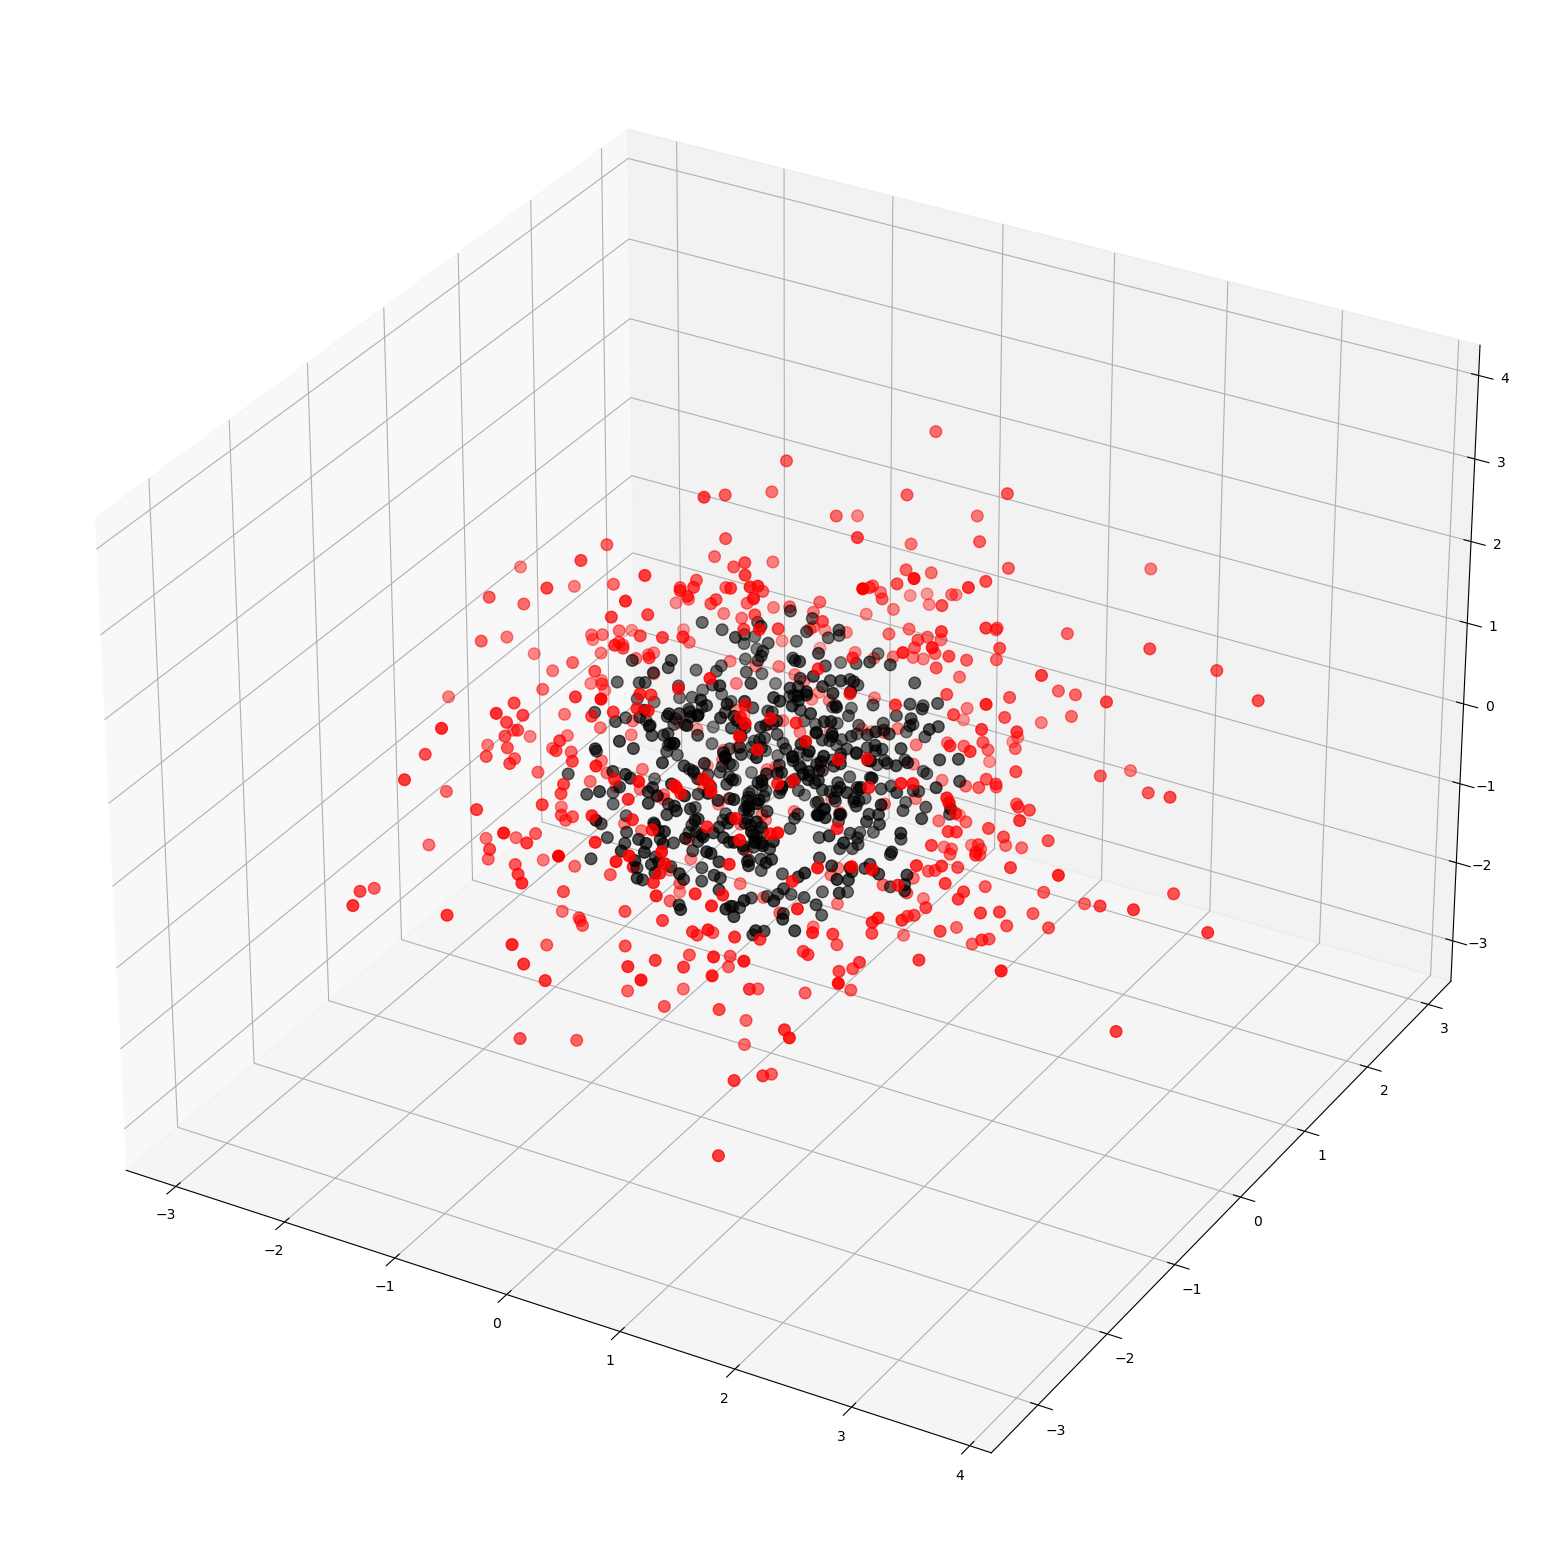

In [69]:
%matplotlib inline
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')
colors = np.array(["black", "red"])
ax.scatter3D(X[:,0], X[:, 1], X[:, 2], marker="o", s=70, c=colors[y])

The data points form a roughly spherical shape with one class (black dots) clustering in the centre and another class (red dots) mostly prevalent away from the centre. And our neural network will have to figure out how to separate the two.

The dataset we'll actually use to train the neural network will be larger.

In [70]:
X, y = make_gaussian_quantiles(n_samples=10000, n_features=3, n_classes=2)

In [71]:
# The first ten samples from our dataset.
print(X[:10])

[[ 0.36908079 -1.02007501 -0.343396  ]
 [ 0.28450949 -0.62031168 -0.29116687]
 [-0.04265472 -1.89707349 -0.13802549]
 [ 2.10596261 -0.28786112 -0.90745068]
 [ 0.9343155  -2.34581461 -0.35963279]
 [-0.20947758 -0.96055877 -0.9500128 ]
 [-1.40114677  0.36721088 -0.86222035]
 [ 2.32302119 -0.55542959 -2.4716959 ]
 [ 0.90254555 -1.34799483  0.64630788]
 [ 0.25039937  0.66535733 -0.51488087]]


In [72]:
# The labels for the first ten samples.
print(y[:10])

[0 0 1 1 1 0 1 1 1 0]


In [73]:
n_samples = X.shape[0]
n_features = X.shape[1]
print(f'Number of samples (rows): {n_samples}, number of features (cols): {n_features}')

Number of samples (rows): 10000, number of features (cols): 3


We'll be using softmax and categorical cross-entropy so we'll one-hot encode the targets.

In [74]:
def one_hot_encode(labels):
  uniques, indices = np.unique(y, return_inverse=True)
  n_rows, n_cols = len(labels), len(uniques)
  one_hot_rows = np.zeros((n_rows, n_cols))
  one_hot_rows[np.arange(n_rows), indices] = 1

  return one_hot_rows

In [75]:
y_one_hot = one_hot_encode(y)
print(y[:10])
print(y_one_hot[:10])

[0 0 1 1 1 0 1 1 1 0]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


Our network will be a three-layer network with two hidden layers of four units each with ReLU activation, and an output layer of two units with softmax. A three-layer network is probably overkill for something simple like this but it's here for demonstration.

In [76]:
n_hidden_units_1 = 4
n_hidden_units_2 = 4

In [77]:
# random.seed is here to ensure we get the same results during this part of the demo.
# Comment the line out to get a different set of weights.
np.random.seed(0)

dense1 = LayerDense(n_features, n_hidden_units_1)
activation1 = ActivationRelu()

dense2 = LayerDense(n_hidden_units_1, n_hidden_units_2)
activation2 = ActivationRelu()

dense3 = LayerDense(n_hidden_units_2, n_classes)
activation_loss = SoftmaxCCECombo()

This *predict* function, which we'll use once the network is trained, takes a batch of input, runs it through the network, and returns the index (i.e. class) of the highest softmax component.

In [78]:
def predict(inputs):
    output = dense1.forward(inputs)
    output = activation1.forward(output)

    output = dense2.forward(output)
    output = activation2.forward(output)

    output = dense3.forward(output)
    preds = activation_loss.forward(output)

    predictions = np.argmax(preds, axis=1)
    return predictions

If we ran our input data through the untrained network, we'd expect it to have ~50% accuracy (our dataset is balanced).

In [79]:
preds = predict(X)

# Accuracy of untrained network.
print(f"Prediction accuracy of untrained network: {np.mean(preds==y)}")

Prediction accuracy of untrained network: 0.497


Starting here, we'll train our network using *batches* of data. We'll learn more about batch training and "epochs" in the next module, but for now:
* An epoch is one pass through our entire training data.
* A batch is a subset of our data. We can split our data into batches of 16, 32, 64, 100, whatever one considers appropriate. Up to this point, we've been training using batches of 1 (i.e. the entire dataset).

For training this network, we'll use batches of size 32 and 30 epochs. 32 was chosen for batch size simply because it's popular, and 30 for epochs was chosen arbitrarily. In the next module, we'll look at a few ways to fine tune these values.

In [80]:
n_epochs = 30
batch_size = 32

In [81]:
# Split both the inputs and targets into batches.
X_batches = [X[i:i+batch_size] for i in range(0, len(X), batch_size)]
y_batches = [y_one_hot[i:i+batch_size] for i in range(0, len(y_one_hot), batch_size)]

In [82]:
# Make sure number of batches match.
print(len(X_batches))
print(len(y_batches))

313
313


This is our training loop. For every epoch, we'll go through our training data one batch at a time, performing a forward pass, backward pass, and gradient descent on a batch before moving on to the next one.<br><br>
We'll also print our average accuracy and loss per epoch to see whether our network is learning over time.

In [83]:
for epoch in range(n_epochs):

  for X_batch, y_batch in zip(X_batches, y_batches):

    accuracy_per_batch = []
    loss_per_batch = []

    # Forward pass.
    output = dense1.forward(X_batch)
    output = activation1.forward(output)

    output = dense2.forward(output)
    output = activation2.forward(output)

    output = dense3.forward(output)
    y_probas = activation_loss.forward(output)

    # Multiply the returned average loss by batch size to reverse the averaging
    # operation. This is because we'll be taking the average across all batches
    # at the end of each epoch.
    loss_per_batch.append(activation_loss.loss(y_batch) * len(y_batch))

    # Calculate accuracy. Convert softmax predictions into class labels.
    # Our targets are one-hot encoded so convert them into plain class
    # labels as well.
    predictions = np.argmax(y_probas, axis=1)
    y_true = np.argmax(y_batch, axis=1)
    accuracy_per_batch.append(predictions==y_true)

    # Backward pass
    dinput = activation_loss.backward(y_batch)
    dinput = dense3.backward(dinput)

    dinput = activation2.backward(dinput)
    dinput = dense2.backward(dinput)

    dinput = activation1.backward(dinput)
    dinput = dense1.backward(dinput)

    # Gradient descent.
    dense3.update(lr=0.01)
    dense2.update(lr=0.01)
    dense1.update(lr=0.01)

  epoch_accuracy = np.mean(accuracy_per_batch)
  epoch_loss = np.mean(loss_per_batch)

  print(f'epoch: {epoch}, ' +
        f'acc: {epoch_accuracy:.3f}, ' +
        f'loss: {epoch_loss:.3f}')

epoch: 0, acc: 0.312, loss: 11.135
epoch: 1, acc: 0.375, loss: 11.166
epoch: 2, acc: 0.375, loss: 11.074
epoch: 3, acc: 0.438, loss: 10.801
epoch: 4, acc: 0.688, loss: 10.340
epoch: 5, acc: 0.750, loss: 9.561
epoch: 6, acc: 0.812, loss: 8.315
epoch: 7, acc: 0.938, loss: 6.583
epoch: 8, acc: 0.938, loss: 5.474
epoch: 9, acc: 1.000, loss: 4.759
epoch: 10, acc: 1.000, loss: 4.238
epoch: 11, acc: 1.000, loss: 3.814
epoch: 12, acc: 1.000, loss: 3.485
epoch: 13, acc: 1.000, loss: 3.224
epoch: 14, acc: 1.000, loss: 3.016
epoch: 15, acc: 1.000, loss: 2.848
epoch: 16, acc: 1.000, loss: 2.710
epoch: 17, acc: 1.000, loss: 2.608
epoch: 18, acc: 1.000, loss: 2.534
epoch: 19, acc: 1.000, loss: 2.476
epoch: 20, acc: 1.000, loss: 2.430
epoch: 21, acc: 1.000, loss: 2.399
epoch: 22, acc: 1.000, loss: 2.375
epoch: 23, acc: 1.000, loss: 2.363
epoch: 24, acc: 1.000, loss: 2.357
epoch: 25, acc: 1.000, loss: 2.364
epoch: 26, acc: 1.000, loss: 2.367
epoch: 27, acc: 1.000, loss: 2.360
epoch: 28, acc: 1.000, lo

A few notes about the training output **assuming you kept the random seed at 0** (if you didn't, the output will look different but you should have roughly the same final performance):
1. The accuracy started out low and then started improving fast around epoch 4. The loss started dropping fast as well.<br>

2. At epoch 9, the accuracy hit 100% and stayed there until the end. This is a clear indication of overfitting which we talked about in the [Building Models](https://www.nlpdemystified.org/course/building-models) module and which we'll talk about a bit more in the next. Essentially, the model has "memorized" the data. The likely culprit is the model is too complex (e.g. too many layers or too many units) relative to the simplicity of the data and the goal. But I wanted to demonstrate multiple hidden layers.

3. You might be wondering about the relationship between **accuracy** and **loss**. For example, why would the loss keep decreasing once accuracy hit 100%?
  * Accuracy is a binary comparison between whether the class with the highest softmax probability matches the target class. It's a "yes" or "no" question regardless of the probability value.
  * Loss is the numeric difference between the softmax probability of the correct class and 1.

So say, during training, the network has this prediction for a sample [0.51, 0.49] and the one-hot encoded target is [1, 0]. In this case, the accuracy is 100% while the loss is the difference between 0.51 and 1. Then after a bit more training, the prediction for the same sample is now [0.9, 0.1]. In this case, accuracy is still 100% but loss (0.9 vs 1) is now lower.


So our network has overfitted the data. Is that automatically a bad thing? It depends on the data and the goal. In our case, the input is always going to be from a well-defined distribution.

To test our trained network, we'll generate a test dataset and ask our network to classify the input. The network hasn't seen this data before.

In [84]:
X_test, y_test = make_gaussian_quantiles(n_samples=100, n_features=3, n_classes=2)

In [85]:
test_preds = predict(X_test)
test_acc = np.mean(test_preds==y_test)
print(f"Accuracy on unseen data: {test_acc}")

Accuracy on unseen data: 0.95


Despite the network being overfitted, the performance on unseen data is still good because of the nature of the input.<br><br>
In other cases, you might have a network with 100s of billions of parameters and trained on terabytes of data. If the network overfits on that data but accumulates so much knowledge about different scenarios that it can still address what we ask of it later, is that necessarily a bad thing? Maybe not.<br><br>
Still, if we can get the same results using a less complex network (i.e. fewer parameters), we should do so simply because it's more efficient in both training and inference time, and storage.

So that's one way to build and train a neural network from scratch. While this is a useful exercise to build intuition and get a sense of what's going on under the hood, we'll be using frameworks from here on out for rapid prototyping and experiments.<br><br>
In the next module, we'll look at a variety of factors when it comes to training neural networks. We'll look at different ways to initialize weights, the different types of activation functions, how to adjust learning rate, and more.

# Neural Networks II: Essential Components and Using a Framework

Course module for this demo: https://www.nlpdemystified.org/course/neural-networks-2

At the time this notebook was created, spaCy had newer releases but Colab was still using version 2.x by default. So the first step is to upgrade spaCy.
<br><br>
**IMPORTANT**<br>
If you're running this in the cloud rather than a local Jupyter server on your machine, then the notebook will *timeout* after a period of inactivity. If that happens and you don't reconnect in time, you will need to upgrade spaCy again and reinstall the requisite statistical package(s).
<br><br>
Refer to this link on how to run Colab notebooks locally on your machine to avoid this issue:<br>
https://research.google.com/colaboratory/local-runtimes.html

In [ ]:
!pip install -U spacy==3.*
!python -m spacy download en_core_web_sm

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import spacy
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

In this demo, we're once again going to use the **20 newgroups** dataset.<br>
https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset
<br><br>
This is so we can see how a neural network approach compares against our previous [Naive Bayes](https://colab.research.google.com/github/futuremojo/nlp-demystified/blob/main/notebooks/nlpdemystified_classification_naive_bayes.ipynb) model.<br>


In [88]:
# Download the *train* dataset without headers, footers, and quotes to make the problem more challenging.
train_corpus = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

## Tokenization

We're going to use **Tensorflow/Keras** to build our model, but stick with spaCy for text preprocessing. While Keras does come with a basic tokenizer, it lacks spaCy's useful, specialist linguistic features.
<br><br>
To that end, we'll load the small English statistical model and create a tokenizer function as we did in the previous demos. We'll also disable named entity recognition and parsing since we don't need them.

In [89]:
# We don't need named entity recognition nor parsing. Removing them will speed up processing.
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [90]:
def spacy_tokenizer(doc):
  return [t.lemma_.lower() for t in nlp(doc) if \
          len(t) > 2 and \
          not t.is_punct and \
          not t.is_space and \
          not t.is_stop and \
          t.is_alpha]

The function below takes some text, runs it through the spaCy tokenizer, then _joins_ the tokens back into a string using a '|' separator. The reason why we're doing this is further below.

In [91]:
def preprocess_text(text):
  tokens = spacy_tokenizer(text)
  return "|".join(tokens)

Next, we'll preprocess each post in the training corpus. In the [topic modelling demo](https://colab.research.google.com/github/futuremojo/nlp-demystified/blob/main/notebooks/nlpdemystified_topic_modelling_lda.ipynb#scrollTo=6siL9mNJxqix), we used **nlp.pipe** to preprocess batches of sentences at a time over multiple processes to speed things up. We'll keep it simple here and preprocess each post sequentially which will take longer.<br><br>
We'll end up with a collection of posts where each token is delimited with '|'.

In [92]:
%%time
preprocessed_train_corpus = [preprocess_text(post) for post in train_corpus.data]

CPU times: user 2min 34s, sys: 7.19 s, total: 2min 41s
Wall time: 2min 41s


In [93]:
print(preprocessed_train_corpus[0])
print(preprocessed_train_corpus[1])

wonder|enlighten|car|see|day|door|sport|car|look|late|early|call|bricklin|door|small|addition|bumper|separate|rest|body|know|tellme|model|engine|spec|year|production|car|history|info|funky|look|car|mail
fair|number|brave|soul|upgrade|clock|oscillator|share|experience|poll|send|brief|message|detail|experience|procedure|speed|attain|cpu|rate|speed|add|card|adapter|heat|sink|hour|usage|day|floppy|disk|functionality|floppy|especially|request|summarize|day|add|network|knowledge|base|clock|upgrade|answer|poll|thank


As before, we'll split the corpus into a training set and validation set.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [95]:
train_data, val_data, train_labels, val_labels = train_test_split(preprocessed_train_corpus, train_corpus.target, train_size=0.85, random_state=1)

In [96]:
print(len(train_data), len(val_data))

9616 1698


At this point, we'll bring in **Keras**. Keras is a deep-learning framework built on top of Tensorflow, and makes it easy to compose models and iterate fast. Most of the time, Keras will provide everything you need but you can drop down to Tensorflow directly for more low-level customization.<br>
https://keras.io/<br>
https://www.tensorflow.org/
<br><br>
There's also **PyTorch** from Meta which is also excellent, popular, and has greater mindshare in research. You can't go wrong with either one.<br>
https://pytorch.org/<br><br>
Both have similar features and even syntax, so don't get caught up in framework wars:<br> https://twitter.com/soumithchintala/status/1263854044289929221
<br><br>
As an aside, the word _tensor_ in Tensorflow simply refers to a mathematical object. It's a generalization of scalars and vectors.  A scalar is a zero-rank tensor, a vector is a first-rank tensor, and so on.<br>
https://www.tensorflow.org/guide/tensor

We're going to use Keras' basic tokenizer to split our posts into sequences of tokens with no further processing.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

Here, we're initializing a tokenizer to do nothing but split text on the '|' character. We're also including an Out-of-Vocabulary token **('OOV')**. Recall that during testing or inference, it's possible for our model to encounter words it didn't see during training. When that happens, the new word is fed into the model as an **'OOV'** token.

In [97]:
tokenizer = keras.preprocessing.text.Tokenizer(filters="", lower=False, split='|', oov_token='OOV')

Calling _fit_on_texts_ generates an internal vocabulary.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#fit_on_texts

In [98]:
tokenizer.fit_on_texts(train_data)

We can look at the tokenizer's internals using the _get_config_ method.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#get_config
<br><br>
We can see information such as how many documents were processed to generate the vocabulary, the frequency of each token, and various indices. Btw--_num_words_ does NOT mean the number of words in the vocabulary. It's actually a parameter we can pass to the tokenizer upon initialization to keep the most frequent {_num_words_} words and to dump the rest. Here, we didn't set any limit.

In [99]:
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '|',
 'char_level': False,
 'oov_token': 'OOV',
 'document_count': 9616,
 'word_counts': '{"sorry": 295, "followup": 49, "email": 685, "address": 706, "try": 1770, "decide": 372, "printer": 250, "like": 3489, "hear": 846, "user": 673, "question": 1448, "thank": 1299, "xrpc": 1, "package": 562, "year": 2395, "believe": 1373, "get": 1897, "export": 163, "anybody": 355, "big": 649, "electron": 29, "noah": 6, "rob": 101, "butera": 1, "ask": 1108, "book": 861, "call": 1022, "lose": 439, "years": 8, "jesus": 682, "elizabeth": 8, "clare": 3, "prophet": 62, "know": 3850, "miss": 277, "leader": 173, "group": 1017, "church": 445, "universal": 52, "triumphant": 3, "derive": 62, "found": 48, "ballard": 4, "begin": 360, "mission": 213, "write": 1129, "memory": 453, "detail": 331, "straight": 143, "old": 865, "account": 246, "check": 577, "library": 315, "bnook": 1, "marcus": 6, "bach": 8, "eighteenth": 4, "century": 154, "frenchman": 1,

To get the size of the vocabulary, we can view the number of entries in *word_index*.

In [100]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")

Vocabulary size: 45379


## Vectorization

The next step is to vectorize our text with a basic (i.e. binary, count, TF-IDF) bag-of-words (BoW) approach. We learned about basic BoW in part one:<br>
https://www.nlpdemystified.org/course/basic-bag-of-words
<br><br>


---


**NOTE:**<br>
Now that we understand how neural networks work, there are **MUCH** better ways to vectorize text than basic bag-of-words for neural network models. But since we haven't learned them yet and this demo is just to get a feel for building neural networks for NLP, we'll stick with BoW for now.


---



The Keras tokenizer's _texts_to_matrix_ method builds a BoW. It can create different BoW types including binary (default), TF-IDF, and others.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_matrix

In [101]:
# Vectorize the first post using binary. We're using [:1] here because the
# tokenizer expects an *array* of sequences.
print(train_data[:1])

# The resulting binary BoW has a 1 set for every word present in the sequence.
binary_bow = tokenizer.texts_to_matrix(train_data[:1])
print(f"Vector shape: {binary_bow.shape}")
print(binary_bow)

['sorry|followup|email|address|try|decide|printer|like|hear|user|printer|question|thank']
Vector shape: (1, 45380)
[[0. 0. 0. ... 0. 0. 0.]]


We can retrieve the original tokens from the BoW by getting the indices which are set to 1, and then looking them up with the tokenizer's *index_word* dictionary.

In [102]:
present_tokens = np.where(binary_bow[0] == 1)[0]
print(f"Token indices: {present_tokens}")
print(" ".join(tokenizer.index_word[n] for n in present_tokens))

Token indices: [   3   27   32   41   96  137  142  146  373  504  617 2591]
like try question thank hear address email user decide sorry printer followup


If we want TF-IDF vectors instead, we can get them by setting the *mode* parameter.

In [103]:
tfidf_bow = tokenizer.texts_to_matrix(train_data[:1], mode='tfidf')
print(tfidf_bow, '\n')

# https://numpy.org/doc/stable/user/basics.indexing.html
print(f"TF-IDF scores of the first post's tokens:\n {tfidf_bow[0][present_tokens]}")

[[0. 0. 0. ... 0. 0. 0.]] 

TF-IDF scores of the first post's tokens:
 [1.67181117 2.17534187 2.46233233 2.21592895 2.78892285 3.28251394
 3.19211311 3.59685722 3.51442517 3.5513158  7.48557896 5.43787225]


For simplicity, we'll stick to binary BoW. Feel free to experiment with different modes to see if you can squeeze better performance.

In addition to vectorizing the text into binary BoWs, we're going to also store them in Tensorflow **sparse matrices**. Our vocabulary is quite large and for each post, very few indices in each vector will be set to 1. This means we'll have large matrices of mostly zeros which is expensive to store and can be problematic for environments such as a free tier of Colab.
<br><br>
Tensorflow **sparse tensors** store these types of data structures more efficiently, and Keras can work seamlessly with them.<br>
https://www.tensorflow.org/api_docs/python/tf/sparse/SparseTensor
<br><br>
We'll vectorize the training data using *texts_to_matrix* and turn the results into a **sparse tensor**.

In [104]:
X_train = tf.sparse.from_dense(tokenizer.texts_to_matrix(train_data))

In the next module, we'll learn a vectorization technique to create smaller, _dense_ vectors that can pack more information beyond just simply indicating whether a word is present.

The shape of the tensor corresponds to the number of tokenized documents (rows) and vocabulary (columns).

In [105]:
X_train.shape

TensorShape([9616, 45380])

We also need to vectorize our labels. Since our goal is multiclass classification, we'll one-hot encode the labels. That is, each label vector will be an array of length 20 (corresponding to the 20 classes) with the index corresponding to the correct class set to 1. The rest will be zero.
<br><br>
Keras has a _to_categorical_ method to help with this.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

In [106]:
print(train_labels)

[ 2  5  4 ... 15  6  2]


In [107]:
y_train = keras.utils.to_categorical(train_labels)

The shape of the tensor corresponds to the number of documents (rows) and classes (columns)

Looking at the first entry in the vectorized labels, we can see its corresponding class.<br>
https://numpy.org/doc/stable/reference/generated/numpy.argmax.html

In [108]:
print(y_train.shape)
print(y_train[0])
print(f"Target/class: {train_corpus.target_names[np.argmax(y_train[0])]}")

(9616, 20)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Target/class: comp.os.ms-windows.misc


We'll vectorize the validation data and labels as well.

In [109]:
X_val = tf.sparse.from_dense(tokenizer.texts_to_matrix(val_data))
y_val = keras.utils.to_categorical(val_labels)

## Building an Initial Model

To build our models, we'll use Keras' **sequential** API which allows us to describe a model layer-by-layer, and provides training and inference features.<br>
https://keras.io/api/models/sequential/<br>
https://keras.io/guides/sequential_model/
<br><br>
The layers themselves are a bunch of classes which we can initialize with parameters such as number of units, which activation function to use, and more. There are a bunch of layers available we can use out-of-the-box and we can also create our own.
<br>
https://keras.io/api/layers/
<br><br>
We can alternatively use the **Functional** API for more flexibility but we'll stick with **Sequential** for now.<br>
https://keras.io/guides/functional_api/

We'll build a simple model with two hidden layers. The output layer uses **softmax** since we're performing multiclass classification.

In [110]:
NUM_CLASSES = len(train_corpus.target_names)
NUM_UNITS = 128

# "set_seed" is called to ensure we get the same weights every time. Comment out this
# line to get different weight initializations.
tf.random.set_seed(0)

# "kernel_initializer" is passed to ensure we get the same weights every time. Remove
# the parameter to get different weight initializations.
model = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
  layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=tf.keras.initializers.random_normal(seed=1))
])

After specifying the layers, we'll *compile* the model and specify which optimizer, loss function, and performance metric we want to use.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#compile<br>
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers<br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses<br>
https://www.tensorflow.org/api_docs/python/tf/keras/metrics

In [111]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Similar to our previous experience with Scikit-learn, we can train a Keras model by calling its _fit_ method and specifying a number of parameters. In this case, we're specifying number of epochs and batch size. We're also passing in our validation data on which the model will evaluate the loss after each epoch.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit

In [112]:
NUM_EPOCHS = 15
BATCH_SIZE = 128

history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/15
76/76 [==============================] - 1s 11ms/step - loss: 2.4539 - accuracy: 0.3674 - val_loss: 1.8658 - val_accuracy: 0.4971
Epoch 2/15
76/76 [==============================] - 1s 9ms/step - loss: 1.3069 - accuracy: 0.7047 - val_loss: 1.3507 - val_accuracy: 0.6113
Epoch 3/15
76/76 [==============================] - 1s 9ms/step - loss: 0.7846 - accuracy: 0.8056 - val_loss: 1.1612 - val_accuracy: 0.6567
Epoch 4/15
76/76 [==============================] - 1s 9ms/step - loss: 0.5177 - accuracy: 0.8749 - val_loss: 1.1117 - val_accuracy: 0.6790
Epoch 5/15
76/76 [==============================] - 1s 10ms/step - loss: 0.3623 - accuracy: 0.9100 - val_loss: 1.1218 - val_accuracy: 0.7002
Epoch 6/15
76/76 [==============================] - 1s 10ms/step - loss: 0.2696 - accuracy: 0.9337 - val_loss: 1.2164 - val_accuracy: 0.6926
Epoch 7/15
76/76 [==============================] - 1s 10ms/step - loss: 0.2106 - accuracy: 0.9482 - val_loss: 1.2421 - val_accuracy: 0.7108
Epoch 8/15
76/76

During training, our model outputted a history of loss and accuracy metrics for both the training set and validation set. We can see the training and validation metrics get better for a certain number of epochs before they start diverging. Performance on the training set keeps improving while performance on the validation set starts degrading at some point, signalling that the model is starting to overfit.
<br><br>
We can plot this information as well.

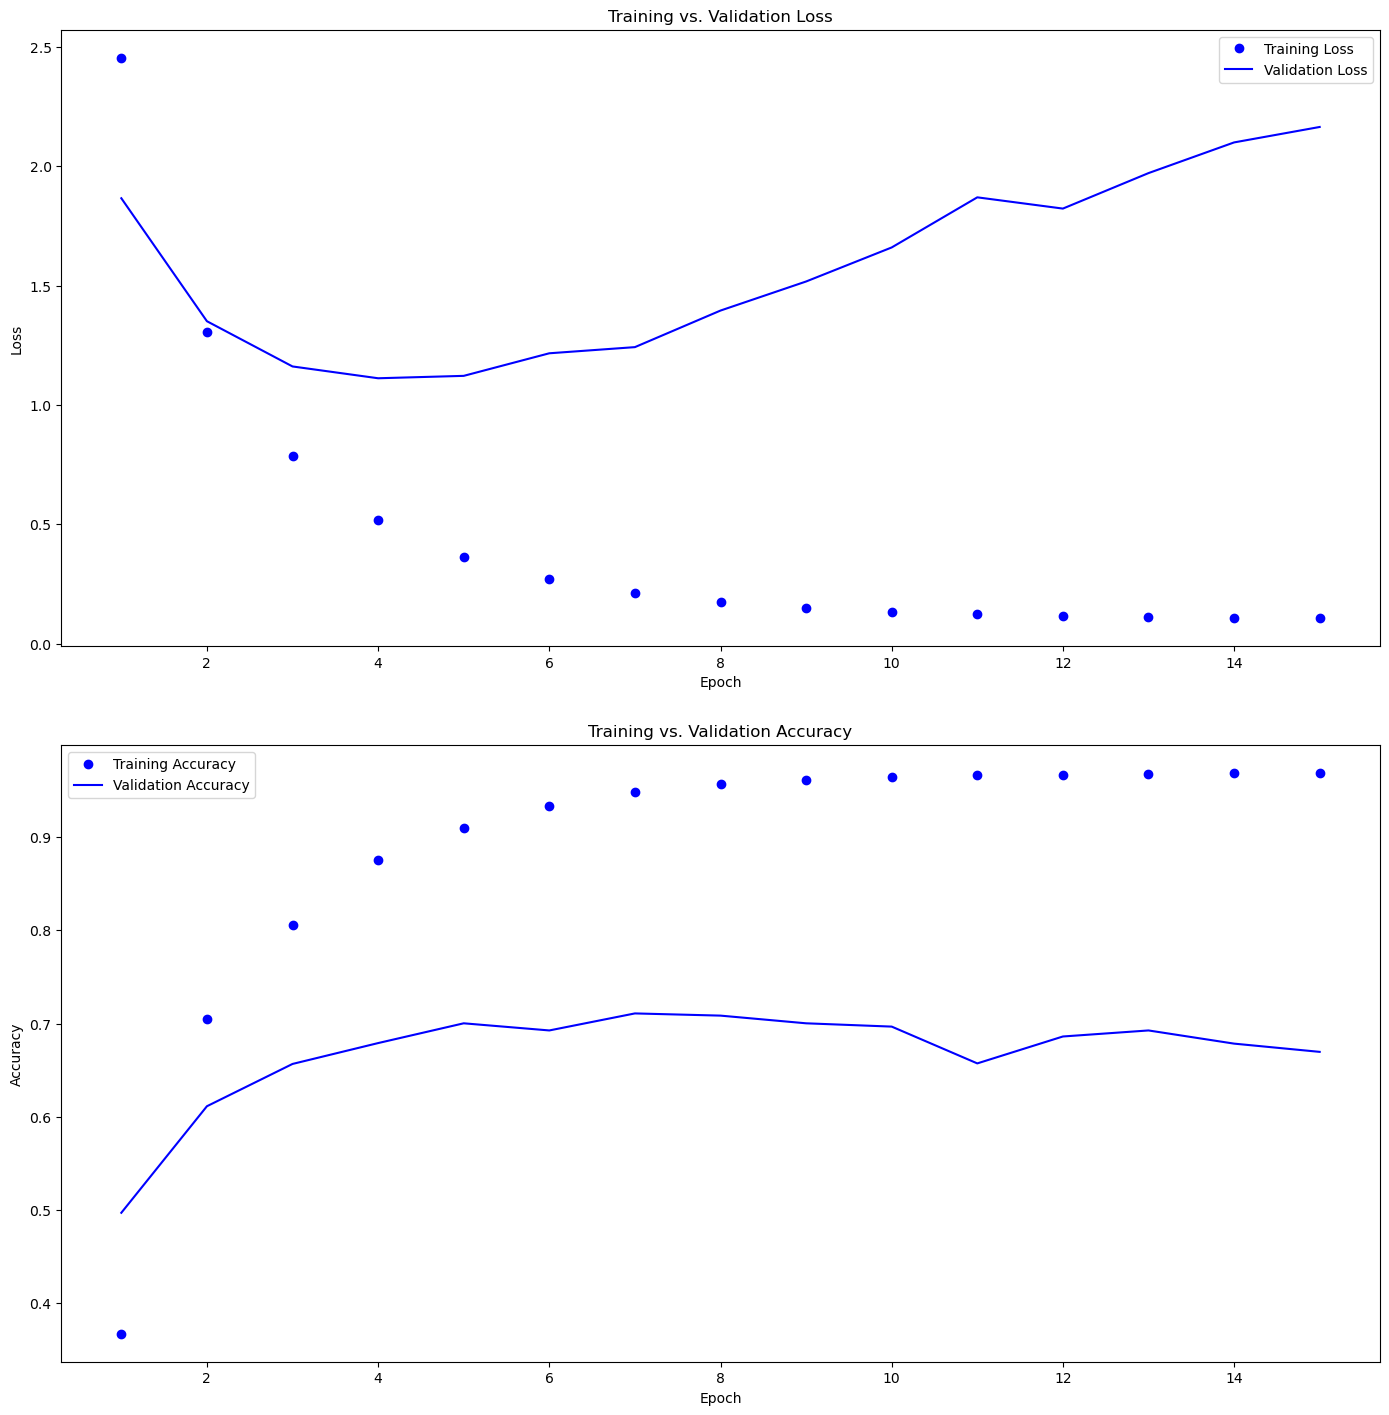

In [113]:
training_losses = history.history['loss']
validation_losses = history.history['val_loss']

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_losses) + 1)

fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout(pad=5.0)

# Plot training vs. validation loss.
ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
ax1.title.set_text('Training vs. Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# PLot training vs. validation accuracy.
ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
ax2.title.set_text('Training vs. Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

Our current model, the way it's trained, has overfit on the data.
<br><br>
Since we have an idea of when that overfitting begins, we can now train a _new_ model that stops training at or right before that point. In the following cell, we'll retrain an identical model but this time with the number of epochs equalling the point where the divergence began in our previous model.


In [115]:
REPLACE_WITH_DESIRED_EPOCHS = 8

tf.random.set_seed(0)
model = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=1)),
  layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=tf.keras.initializers.random_normal(seed=1))
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=REPLACE_WITH_DESIRED_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/8


76/76 [==============================] - 1s 10ms/step - loss: 2.4539 - accuracy: 0.3674 - val_loss: 1.8658 - val_accuracy: 0.4971
Epoch 2/8
76/76 [==============================] - 1s 9ms/step - loss: 1.3069 - accuracy: 0.7047 - val_loss: 1.3507 - val_accuracy: 0.6113
Epoch 3/8
76/76 [==============================] - 1s 9ms/step - loss: 0.7846 - accuracy: 0.8056 - val_loss: 1.1612 - val_accuracy: 0.6567
Epoch 4/8
76/76 [==============================] - 1s 9ms/step - loss: 0.5177 - accuracy: 0.8749 - val_loss: 1.1117 - val_accuracy: 0.6790
Epoch 5/8
76/76 [==============================] - 1s 9ms/step - loss: 0.3623 - accuracy: 0.9100 - val_loss: 1.1218 - val_accuracy: 0.7002
Epoch 6/8
76/76 [==============================] - 1s 9ms/step - loss: 0.2696 - accuracy: 0.9337 - val_loss: 1.2164 - val_accuracy: 0.6926
Epoch 7/8
76/76 [==============================] - 1s 9ms/step - loss: 0.2106 - accuracy: 0.9482 - val_loss: 1.2421 - val_accuracy: 0.7108
Epoch 8/8
76/76 [===================

We can look at a summary of our model using the _summary_ method.


In [116]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               5808768   
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 20)                2580      
                                                                 
Total params: 5827860 (22.23 MB)
Trainable params: 5827860 (22.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Looking at the preceding summary, there's an outsized number of parameters (i.e. weights) in the first layer because the BoW encoding results in a wide vocabulary array. This isn't great.
<br><br>
If you're wondering where that _param_ number comes from, here's how it's calculated:



In [117]:
# Size of vocabulary. The '+ 1' is because the zero index is reserved for padding.
v = (len(tokenizer.word_index) + 1)
print(f"Size of vocabulary/number of columns in BoW array (v): {v}")

n = NUM_UNITS
print(f"Number of units in the first layer(n): {n}\n")

# The '+ n' accounts for the number of biases. Each unit has one.
p = v * n + n
print(f"Number of params in the first layer(p) = v * n + n = {p}")

Size of vocabulary/number of columns in BoW array (v): 45380
Number of units in the first layer(n): 128

Number of params in the first layer(p) = v * n + n = 5808768


We can look at the weights in each layer as well using the _get_weights_ method. Here are the weights of the first layer. It's a two-element array where the first contains the non-bias weights and the second contains the bias weights.<br>
https://keras.io/api/layers/base_layer/#getweights-method

In [120]:
model.layers[0].get_weights()

[array([[ 0.00633252, -0.02465083,  0.03155954, ...,  0.05510619,
          0.0270196 ,  0.02357678],
        [-0.05220519, -0.05705109, -0.05572385, ..., -0.02488913,
         -0.00772499,  0.03230472],
        [-0.01586189, -0.05672336,  0.02589948, ...,  0.03293198,
          0.07562427,  0.07837134],
        ...,
        [ 0.03357083,  0.00714637,  0.08401559, ...,  0.04170488,
          0.07196893, -0.00674824],
        [-0.09061699, -0.04612615,  0.00571629, ...,  0.07646   ,
         -0.0099509 , -0.02142934],
        [-0.06344522, -0.03972972,  0.00171669, ...,  0.06525069,
          0.08815064,  0.05463772]], dtype=float32),
 array([0.09554623, 0.11771248, 0.10967377, 0.07979608, 0.11600603,
        0.07311882, 0.10902157, 0.13100599, 0.14922084, 0.11450599,
        0.11222661, 0.1204991 , 0.09949777, 0.15302216, 0.11436684,
        0.10777812, 0.1315296 , 0.11303539, 0.13509132, 0.0955211 ,
        0.12530716, 0.13502713, 0.10449978, 0.10131062, 0.10345426,
        0.10425886

And these are the weights from the first layer's first unit without the bias.

In [137]:
ws = model.layers[0].get_weights()[0][0]
print(len(ws))
ws

128


array([ 0.00633252, -0.02465083,  0.03155954, -0.03944233,  0.02841545,
       -0.07784969, -0.07214358,  0.01211157, -0.11347484,  0.05113735,
        0.02510856, -0.19483842,  0.05845584,  0.0089512 ,  0.0132828 ,
       -0.01544286,  0.09238126, -0.0490174 ,  0.09657896, -0.08423332,
        0.05498499, -0.03655428,  0.01454775, -0.04559011, -0.05393646,
       -0.02843217,  0.04433785, -0.03723487, -0.03797784, -0.04369315,
       -0.05825317, -0.01236771,  0.02006781,  0.02785707, -0.04004025,
        0.02495876,  0.01514242,  0.0972392 ,  0.02680153, -0.02578488,
       -0.01950794,  0.000305  ,  0.01816095, -0.0309119 , -0.01024365,
        0.07917755, -0.01968769,  0.00057877, -0.01045427,  0.05018104,
       -0.01685247,  0.04022045, -0.0784259 ,  0.00790154,  0.02111397,
        0.0410518 ,  0.01375475, -0.06683829,  0.01404174,  0.00986658,
        0.04986066, -0.01828479, -0.00456914, -0.00223281,  0.04473996,
       -0.01042102, -0.02548703,  0.05005852, -0.04727412,  0.01

In [138]:
#I would call the above the weights of the first vocab dimension across units bc we specified 128 units and it has length 128
#each unit is 45380 dimensions because of vocab

np.shape(model.layers[0].get_weights()[0])

(45380, 128)

In [130]:
#first bias term
model.layers[0].get_weights()[1][0]

0.09554623

Let's try our model on the test set. We'll download it without the metadata, preprocess it, then vectorize the inputs and targets.

In [136]:
test_corpus = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [141]:
%%time
preprocessed_test_corpus = [preprocess_text(post) for post in test_corpus.data]

CPU times: user 1min 39s, sys: 6.68 s, total: 1min 46s
Wall time: 1min 46s


In [142]:
X_test = tf.sparse.from_dense(tokenizer.texts_to_matrix(preprocessed_test_corpus))
y_test = keras.utils.to_categorical(test_corpus.target)

Since we're evaluating the model on the test set, we'll use the _evaluate_ method.<br>
https://keras.io/api/models/model_training_apis/#evaluate-method

In [143]:
results = model.evaluate(X_test, y_test)

236/236 [==============================] - 0s 1ms/step - loss: 1.9045 - accuracy: 0.6334


_evaluate_ returns a two-element list with the loss as the first entry and the metric of interest as the second entry.

In [144]:
print(f"Test loss: {results[0]}")
print(f"Test accuracy: {results[1]}")

Test loss: 1.9044866561889648
Test accuracy: 0.6334307193756104


Random guessing would result in an accuracy of ~5% (since there are 20 classes and the data is balanced), so the results are much better than that. But it's still not very satisfying and it falls short of our naive bayes classifier.
<br><br>
Let's take a look at a confusion matrix and classification report. To generate those, we'll need the actual predictions from the model which we'll generate using the _predict_ method.
<br>
https://keras.io/api/models/model_training_apis/#predict-method

In [145]:
y_pred_probs = model.predict(X_test, verbose=1)

236/236 [==============================] - 0s 1ms/step


The output layer ends with a softmax, so each y_pred element is a **probability distribution**. We need to extract the most probable class. We can do that using numpy's *argmax*:<br>
https://numpy.org/doc/stable/reference/generated/numpy.argmax.html

In [146]:
print(f"Softmax for first post:\n {y_pred_probs[0]}\n")

# Get class with highest probability from each softmax output.
y_preds = np.argmax(y_pred_probs, axis=1)

print(f"Class with highest probability for first test post: {y_preds[0]}")
print(f"Text label: {train_corpus.target_names[y_preds[0]]}")

Softmax for first post:
 [1.8346982e-06 1.2007405e-04 1.8934562e-03 2.0718595e-01 2.9076770e-01
 1.9804877e-07 5.1084477e-03 4.8917058e-01 1.4532661e-03 4.0544728e-05
 4.5643392e-05 1.1247050e-05 3.5074071e-03 3.1757496e-05 5.7988596e-04
 4.4590394e-07 2.4275503e-06 6.6207079e-08 4.1743446e-05 3.7322461e-05]

Class with highest probability for first test post: 7
Text label: rec.autos


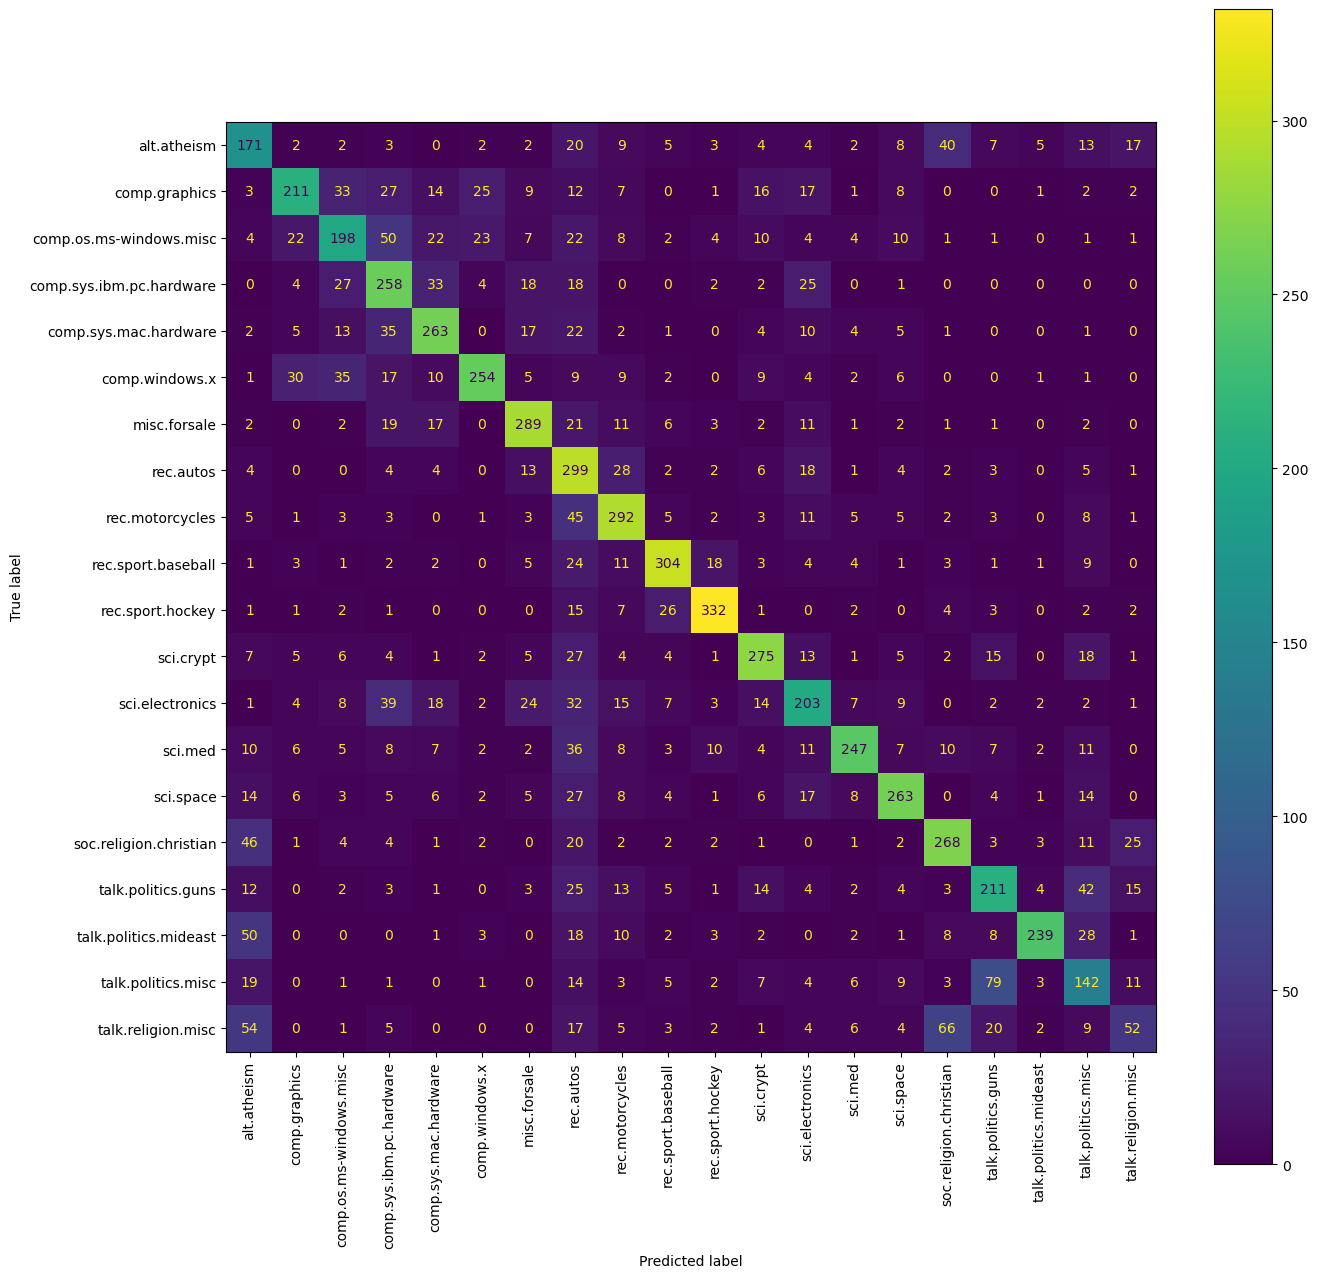

In [147]:
# Not normalizing this time. Just looking at raw numbers.
cm = confusion_matrix(test_corpus.target, y_preds)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_corpus.target_names)
fig, ax = plt.subplots(figsize=(15, 15))
cmd.plot(ax=ax, xticks_rotation='vertical')

A few observations:
- The same patterns from the naive bayes classifier can be seen here. There's a cluster of brighter squares around the technology-related subjects (pc.hardware, mac.hardware, electronics, etc), and subjects such as athiesm, christianity, guns, and politics are confused for each other which drag the overall accuracy down.
- The more focused topics have brighter diagonal squares.

In [148]:
print(classification_report(test_corpus.target, y_preds, target_names=test_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.42      0.54      0.47       319
           comp.graphics       0.70      0.54      0.61       389
 comp.os.ms-windows.misc       0.57      0.50      0.54       394
comp.sys.ibm.pc.hardware       0.53      0.66      0.59       392
   comp.sys.mac.hardware       0.66      0.68      0.67       385
          comp.windows.x       0.79      0.64      0.71       395
            misc.forsale       0.71      0.74      0.73       390
               rec.autos       0.41      0.76      0.53       396
         rec.motorcycles       0.65      0.73      0.69       398
      rec.sport.baseball       0.78      0.77      0.77       397
        rec.sport.hockey       0.85      0.83      0.84       399
               sci.crypt       0.72      0.69      0.71       396
         sci.electronics       0.56      0.52      0.54       393
                 sci.med       0.81      0.62      0.70       396
         

Let's take a look at some posts in a class with **low precision** and **high recall**.

In [151]:
# The class with low precision and high recall from the classification report.

REPLACE_WITH_CLASS_LABEL_OF_INTEREST = 'rec.autos'

class_of_interest = test_corpus.target_names.index(REPLACE_WITH_CLASS_LABEL_OF_INTEREST)
class_of_interest

7

What we'll do here is:
1. Get the posts which were classified under this class.
2. Get ALL posts which are misclassified.
3. Get the posts which were misclassified under this class.

In [152]:
# Get the indices of posts which were classified under this class.
class_preds = np.where(y_preds == class_of_interest)[0]
print(class_preds)

[   0   13   27   28   29   54   60   62   71   75   77   87  101  142
  143  147  160  169  171  174  183  201  205  213  220  226  228  230
  239  241  256  259  263  299  313  318  320  323  343  355  356  362
  383  384  388  390  411  434  459  468  478  497  502  504  506  514
  521  522  534  541  542  563  568  599  617  618  622  624  626  645
  648  655  661  667  678  693  698  720  726  734  745  755  757  761
  762  774  784  809  821  856  858  883  903  906  916  957  959  963
  966  974  975  980 1004 1055 1071 1078 1081 1082 1102 1120 1128 1156
 1159 1168 1171 1206 1210 1232 1247 1290 1298 1351 1353 1363 1379 1388
 1402 1407 1412 1425 1439 1450 1458 1469 1472 1474 1490 1499 1516 1518
 1527 1529 1537 1538 1560 1568 1576 1594 1597 1613 1628 1630 1680 1684
 1685 1707 1718 1736 1738 1752 1756 1757 1785 1796 1797 1802 1815 1816
 1827 1832 1840 1860 1862 1921 1947 1948 1959 1961 1967 1968 1987 1989
 2000 2034 2040 2042 2055 2056 2057 2061 2067 2120 2124 2142 2144 2149
 2151 

In [153]:
# Get the indices of misclassified posts.
misclassified_posts = np.nonzero(test_corpus.target != y_preds)[0]
print(misclassified_posts)

[   1    3    4 ... 7529 7530 7531]


We can get the posts misclassified under this class using:<br>
https://numpy.org/doc/stable/reference/generated/numpy.in1d.html

In [154]:
misclassified_specific = class_preds[np.in1d(class_preds, misclassified_posts)]
print(misclassified_specific)

[  13   29   54   60   62   71   87  101  147  160  174  183  205  213
  228  230  259  263  299  313  318  320  323  356  384  434  459  468
  497  502  504  514  521  522  541  542  563  599  622  624  626  648
  678  693  698  720  755  784  809  821  858  883  906  957  963  974
  980 1004 1071 1078 1120 1156 1168 1171 1206 1232 1247 1290 1353 1363
 1388 1407 1412 1450 1458 1472 1474 1490 1499 1516 1518 1537 1538 1560
 1568 1594 1597 1613 1628 1630 1680 1684 1685 1707 1718 1736 1738 1757
 1796 1797 1802 1816 1827 1832 1840 1948 1959 1961 1968 2000 2034 2040
 2055 2057 2067 2120 2144 2162 2208 2239 2241 2242 2245 2282 2308 2309
 2311 2315 2325 2334 2361 2367 2403 2448 2492 2512 2523 2525 2528 2564
 2599 2606 2613 2622 2652 2657 2689 2698 2716 2741 2796 2806 2808 2810
 2819 2835 2836 2837 2850 2895 2930 2954 2955 3017 3041 3067 3074 3075
 3095 3107 3138 3141 3152 3209 3211 3214 3224 3261 3273 3295 3318 3320
 3328 3343 3355 3363 3383 3390 3399 3421 3500 3512 3545 3554 3556 3607
 3615 

Let's take a look at the content of a few of the posts misclassified under this class.

In [155]:
for post_idx in misclassified_specific[:10]:
  print("Predicted class: {}".format(test_corpus.target_names[y_preds[post_idx]]))
  print("Actual class: {}".format(test_corpus.target_names[test_corpus.target[post_idx]]))
  print("Post: {}".format(preprocessed_test_corpus[post_idx]))
  print()

Predicted class: rec.autos
Actual class: rec.motorcycles
Post: accusation|think|recommendation|mean|grow|oughta|know|bring|truck|pound|crawfish|talk

Predicted class: rec.autos
Actual class: comp.sys.ibm.pc.hardware
Post: know|canada|hear|people|translation|work|papua|new|quinea|like|good|response|service|seriously|consider|buy

Predicted class: rec.autos
Actual class: comp.graphics
Post: find

Predicted class: rec.autos
Actual class: rec.motorcycles
Post: have|problem|instability|universal|gravitational|constant|day|close|get|expose|fang|dripping|doubt|viscera|foolhardy|experimenter|cum|canine|psychology|big|heavy|dog|appear|recall|distribution|pound|operate|muscle|drive|ounce|brain|possess|instinctual|heuristic|compose|equal|part|bloodlust|raven|hunger|course|dog|poop|vary|place|dog|deposit|regularly|painstakingly|manicure|tend|lawn|dog|owner|neighbor|whilst|continuously|replenish|inexhaustible|supply|doubt|consume|like|folk|like|thought|time|look|formidable|instrument|mayhem|realize

A number of these posts:
1. have just a handful of words such that they can't be classified.
2. are ambiguous with little context such that a human would have a hard time.

## Making Another Attempt

Before building another model, let's throw away any preprocessed posts with fewer than five words.

In [156]:
def filter_short_texts(text, min_len, split_char):
  tokens = text.split(split_char)
  return len(tokens) >= min_len

In [157]:
print('Number of training posts before filtering short texts: {}'.format(len(preprocessed_train_corpus)))

# Filter training corpus.
z = zip(preprocessed_train_corpus, train_corpus.target)
f = filter(lambda t: filter_short_texts(t[0], 5, '|'), z)
preprocessed_train_corpus, train_corpus.target = zip(*f)

print('Number of training posts after filtering short texts: {}'.format(len(preprocessed_train_corpus)))

Number of training posts before filtering short texts: 11314
Number of training posts after filtering short texts: 10616


In [158]:
# Do the same for the test corpus.

print('Number of testing posts before filtering short texts: {}'.format(len(preprocessed_test_corpus)))

z = zip(preprocessed_test_corpus, test_corpus.target)
f = filter(lambda t: filter_short_texts(t[0], 5, '|'), z)
preprocessed_test_corpus, test_corpus.target = zip(*f)

print('Number of testing posts before filtering short texts: {}'.format(len(preprocessed_test_corpus)))

Number of testing posts before filtering short texts: 7532
Number of testing posts before filtering short texts: 7044


In [159]:
# Resplit the training data into train/validation sets.
train_data, val_data, train_labels, val_labels = train_test_split(preprocessed_train_corpus, train_corpus.target, train_size=0.85, random_state=1)

In [160]:
# Re-vectorize the training, validation, and test data.
X_train = tf.sparse.from_dense(tokenizer.texts_to_matrix(train_data))
y_train = keras.utils.to_categorical(train_labels)

X_val = tf.sparse.from_dense(tokenizer.texts_to_matrix(val_data))
y_val = keras.utils.to_categorical(val_labels)

X_test = tf.sparse.from_dense(tokenizer.texts_to_matrix(preprocessed_test_corpus))
y_test = keras.utils.to_categorical(test_corpus.target)

For the next attempt, we'll add another dense layer and follow that with some **dropout** regularization. We'll also initialize with **He initialization**.<br>
https://keras.io/api/layers/regularization_layers/dropout/<br>
https://keras.io/api/layers/initializers/#layer-weight-initializers
<br><br>
We'll also leverage **early stopping** to halt training once our validation stops improving. This'll save us the trouble of manually training another model with fewer epochs as we did with the previous model. This is done through a **callback**. Here, the **patience** parameter specifies how many epochs to process with no improvement before training stops. Since we saw in the early graphs that validation loss diverges pretty sharply, we're setting it to 1. If you saw that validation tends to plateau for a bit before improving again, you could consider setting a higher value. There are other settings worth reading about as well.<br>
https://keras.io/api/callbacks/<br>
https://keras.io/api/callbacks/early_stopping/<br>



In [161]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

tf.random.set_seed(0)
initializer = tf.keras.initializers.HeNormal(seed=1)

model_next = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dropout(0.3),
  layers.Dense(NUM_CLASSES, activation='softmax')
])

model_next.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_next.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[es_callback])

Epoch 1/15
71/71 [==============================] - 1s 12ms/step - loss: 1.9529 - accuracy: 0.4987 - val_loss: 1.1375 - val_accuracy: 0.7282
Epoch 2/15
71/71 [==============================] - 1s 12ms/step - loss: 0.7124 - accuracy: 0.8219 - val_loss: 0.8667 - val_accuracy: 0.7671
Epoch 3/15
71/71 [==============================] - 1s 11ms/step - loss: 0.3056 - accuracy: 0.9279 - val_loss: 0.9080 - val_accuracy: 0.7615


Evaluate the new model on the test set to see if there's any improvement.

In [162]:
results = model_next.evaluate(X_test, y_test)

221/221 [==============================] - 0s 1ms/step - loss: 1.3352 - accuracy: 0.6901


Get class predictions on the test set and view a confusion matrix.

221/221 [==============================] - 0s 1ms/step


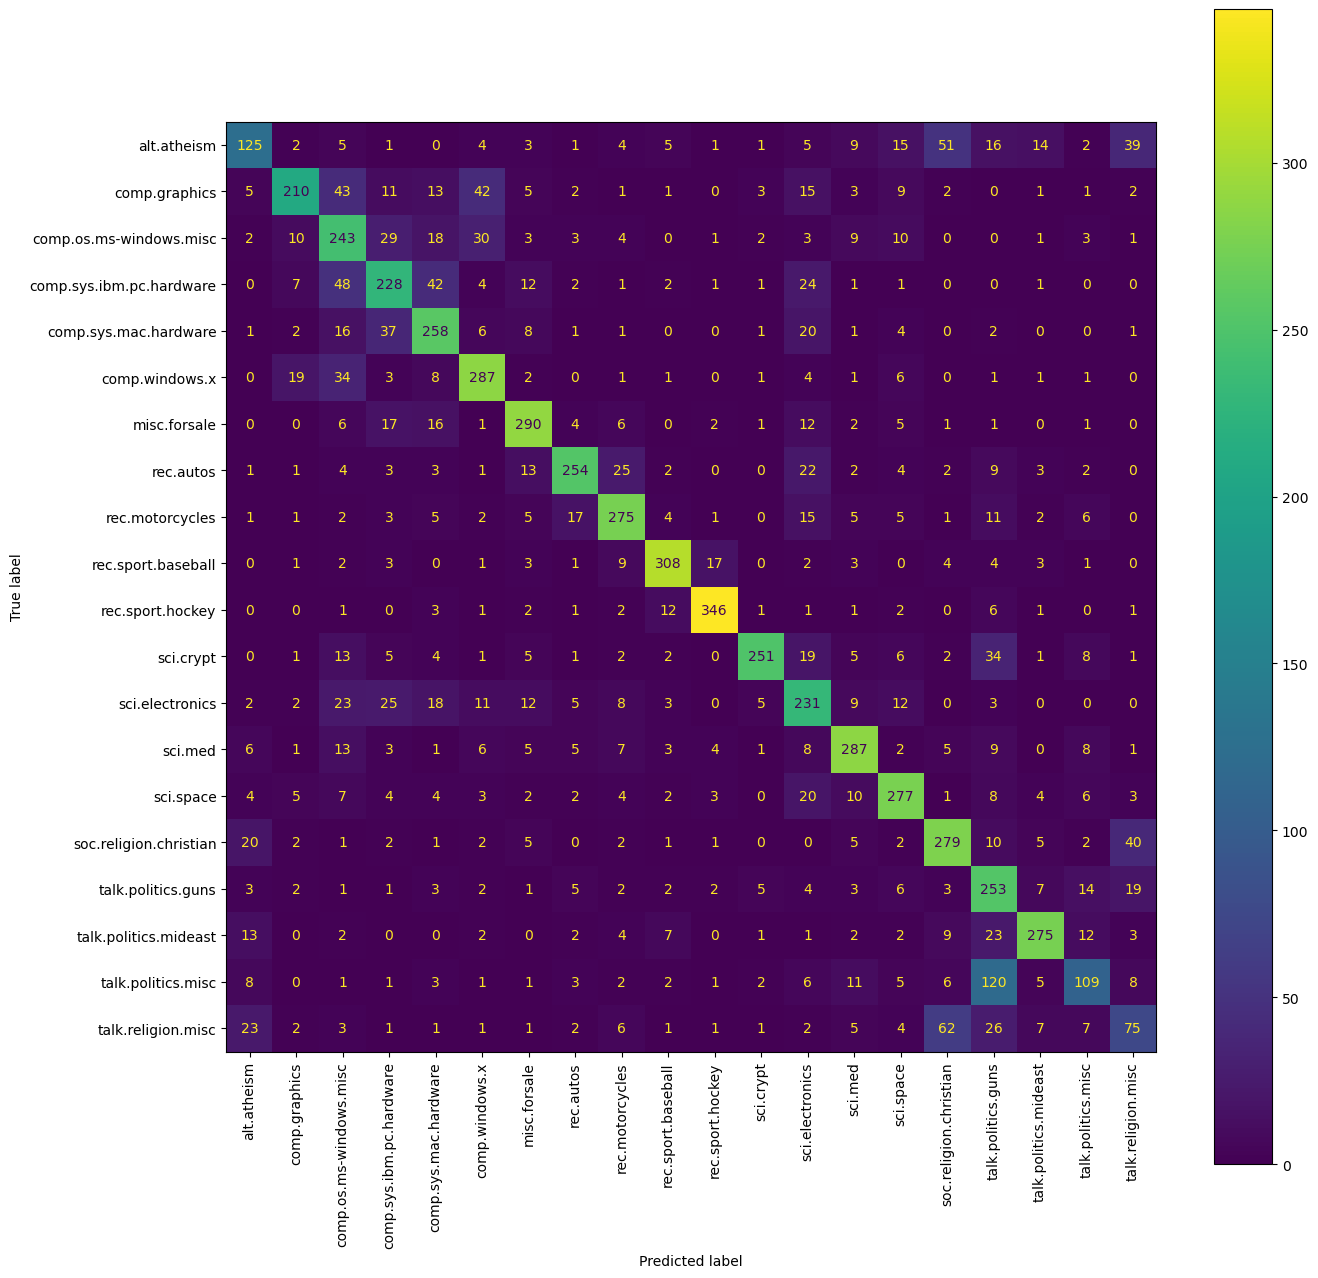

In [163]:
y_pred_probs = model_next.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Not normalizing this time. Just looking at raw numbers.
cm = confusion_matrix(test_corpus.target, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_corpus.target_names)
fig, ax = plt.subplots(figsize=(15, 15))
cmd.plot(ax=ax, xticks_rotation='vertical')

Check out the classification report.

In [164]:
print(classification_report(test_corpus.target, y_pred, target_names=test_corpus.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.58      0.41      0.48       303
           comp.graphics       0.78      0.57      0.66       369
 comp.os.ms-windows.misc       0.52      0.65      0.58       372
comp.sys.ibm.pc.hardware       0.60      0.61      0.61       375
   comp.sys.mac.hardware       0.64      0.72      0.68       359
          comp.windows.x       0.70      0.78      0.74       370
            misc.forsale       0.77      0.79      0.78       365
               rec.autos       0.82      0.72      0.77       351
         rec.motorcycles       0.75      0.76      0.76       361
      rec.sport.baseball       0.86      0.85      0.86       362
        rec.sport.hockey       0.91      0.91      0.91       381
               sci.crypt       0.91      0.70      0.79       361
         sci.electronics       0.56      0.63      0.59       369
                 sci.med       0.77      0.77      0.77       375
         

Compared to the previous model, this improved model has lower loss, higher accuracy, and doesn't have any unusual discrepancies between precision and recall outside of the usual problematic classes (tech/religion/politics). It's now on par with our Naive Bayes classifier though it doesn't beat it. More on this below.

Let's use our improved model for some inference. The function below takes some text, tokenizes and vectorizes it, then returns the model's classification for it.

In [165]:
target_names = test_corpus.target_names.copy()

def classify_post(post):
  vectorized_post = tokenizer.texts_to_matrix([('|').join(spacy_tokenizer(post))])
  probs = model_next.predict(vectorized_post)
  pred = np.argmax(probs, axis=1)[0]
  return target_names[pred], probs[0][pred]

We'll test the model on a bunch of posts from Reddit.

In [166]:
# Post from r/medicine.
s = "New primary care attending here. Why are all my new patients age 60-80 yo on Ambien? Serious question, why? Was there a strong marketing push at this time frame? Was it given out like candy to anyone who said they had some trouble with sleep? Was there any discussion of risks and duration of therapy? Has anyone had success/tips for weaning them off of it?"
classify_post(s)

1/1 [==============================] - 0s 32ms/step


('sci.med', 0.9502798)

In [167]:
# Post from r/space.
s = "James Webb Space Telescope has successfully deployed its forward sunshield pallet! Next up: aft sunshield deployment"
classify_post(s)

1/1 [==============================] - 0s 14ms/step


('sci.space', 0.94575006)

In [168]:
# Post from r/cars.
s = "Cars made in the last 10 years with a 4 Speed Manual Transmission? As per the title really, I’m wondering if any vehicles have been made in the last 10 years that still utilise a 4 speed (or less) manual transmission. My Google research has thus far not turned up any results."
classify_post(s)

1/1 [==============================] - 0s 12ms/step


('rec.autos', 0.8517092)

In [169]:
# Post from r/electronics.
s = "This project is powered by an ATTiny85. Five of its pins were used, three of them for the MAX7219 module controling the 7-segment display and one for the button and piezo buzzer respectively. The user can give input through the button. A normal short press to count one up and a long 6-second press to reset it to 0. I also added a simple switch. The microcontroller stores the value in its EEPROM so it doesn't lose it when powered off. I used a charger of an old phone as a power supply. My dad was really excited when he got it for Christmas and it should certainly help him quit smoking :)"
classify_post(s)

1/1 [==============================] - 0s 15ms/step


('sci.electronics', 0.9995364)

So at this point, we have a model that roughly matches the performance of the naive bayes classifier. You could further experiment with a bunch of other things from what we learned:
- Use a different tokenizer mode (e.g. count or TF-IDF).
- Filter out words based on frequency (e.g. bottom and top 20%).
- Train with much more data.
- Use another optimizer.
- Use more layers (deeper network) or more units in a layer (wider network).
- Tweak the regularization.
<br><br>

That being said, it's going to be difficult to squeeze much more performance because:
- Stripped of metadata, a lot of these posts are ambiguous such that a human would have a hard time classifying them.
- Our BoW encoding is also subpar in that it's large but encodes no information beyond whether a word is present. Especially with the overlapping topics which drag the overall accuracy down, throwing away context makes it much harder to classify.
- Because our input vectors are extremely wide and sparse, we're forced to reduce it down aggressively to a manageable number of units in the first layer. If we were to have a first layer with 20,000 units for example (roughly half of the vocabulary size), that layer alone would have over 800 million parameters which is absurd for a problem of this nature.
<br><br>

But this dataset was used because, beyond putting what we learned into practice, it's a lesson that dirty/low-signal data and information loss during vectorization has a heavy influence on downstream work and performance. If the data is low-quality and the vectorization technique is subpar, then throwing more layers at the problem won't help.
<br><br>
In the rest of the course, we'll learn vectorization techniques which encode much more information in a much smaller space.

## Additional Reading
If you're curious about how to build a custom model using the low-level features of Tensorflow, here are a few links to work through:<br>
https://www.tensorflow.org/tutorials/customization/basics<br>
https://www.tensorflow.org/tutorials/customization/custom_layers<br>
https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough<br>
https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit<br><br>

PyTorch Tutorials:<br>
https://pytorch.org/tutorials/beginner/basics/intro.html<br>
https://pytorch.org/tutorials/beginner/pytorch_with_examples.html<br>
https://pytorch.org/tutorials/beginner/nn_tutorial.html

## Practice

Tensorflow comes with a number dataset loaders, one of which is a collection of ~11,000 Reuters news articles in 46 categories.
<br><br>
Retrieve the data, vectorize both the articles and labels, and build a model to classify the articles.

In [ ]:
from tensorflow.keras.datasets import reuters

In [ ]:
# Call the load_data method to retrieve the train and test sets. Explore the load_data
# method to see what options there are (e.g. limiting the number of words).
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data
#
# NOTE: The load_data method doesn't return arrays of strings, but rather
# arrays of integers. Each news article is encoded as a sequence of integers. There's
# no need to tokenize. You can recreate the article using get_word_index.
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/get_word_index
#


In [ ]:
# Vectorize X_train and X_test (i.e. the articles) as some bag of words matrices.
# Maybe you can use the Keras Tokenizer?
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer


In [ ]:
# Vectorize y_train and y_test (i.e. the labels) as one-hot/categorical encodings.


In [ ]:
# Create your model architecture here.
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
  # Your layers here
])

In [ ]:
# Compile your model here specifying an optimizer, loss function, and performance metric.


In [ ]:
# Fit your model on your test set using early stopping. Optionally divide the test set
# into test/validation splits and pass the validation data to the fit method.


In [ ]:
# If you're satisfied, evaluate the model on the test set and see what you get.
